In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
import os
import json
from sklearn.decomposition import PCA
import umap.umap_ as umap
from itertools import permutations
np.random.seed(42)

%matplotlib inline  
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

In [2]:
# Set data input folder
# Download files described in README.md to this folder
input_folder = "inputs"

# Set output folder, subfolder
output_folder = "outputs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder, exist_ok=True)
if not os.path.exists(os.path.join(output_folder,"figure_panels")):
    os.makedirs(os.path.join(output_folder,"figure_panels"), exist_ok=True)

In [3]:
# Import the HeLa DMEM gene-level profiles
df_gene_DMEM = pd.read_csv("../Profile_Aggregation/outputs/20210422_6W_CP257_guide_normalized_feature_select_median_merged_ALLBATCHES___DMEM___ALLWELLS_gene_aggregated.csv.gz").set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')
# Import the HeLa HPLM gene-level profiles
df_gene_HPLM = pd.read_csv("../Profile_Aggregation/outputs/20210422_6W_CP257_guide_normalized_feature_select_median_merged_ALLBATCHES___HPLM___ALLWELLS_gene_aggregated.csv.gz").set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')

# Import annotated gene sets
with open("../common_files/annotated_gene_sets.json") as f:
    gene_set_dict = json.load(f)

# Load p_values from the hit calling process
df_p_values_DMEM = pd.read_csv('../Hit_Calling/outputs/HeLa_DMEM_significant_features_mann_whitney_p_values.csv.gz')
df_p_values_DMEM = df_p_values_DMEM.set_index('Gene')
df_p_values_HPLM = pd.read_csv('../Hit_Calling/outputs/HeLa_HPLM_significant_features_mann_whitney_p_values.csv.gz')
df_p_values_HPLM = df_p_values_HPLM.set_index('Gene')

# Load expression data 
with open("../Hit_Calling/outputs/HeLa_CCLE_expression_summary.json") as f:
    express = json.load(f)
    zero_tpm_list = express['zero_tpm']
    expressed_gene_list = express['expressed_genes']

# Input the protein clusters from the CORUM and STRING databases
CORUM_data = pd.read_csv('../common_files/CORUM_humanComplexes.txt',sep = '\t')
STRING_data = pd.read_csv('../common_files/STRING_data.csv.gz')

# Input the protein clusters from the CORUM
ppi_data = pd.read_csv('../common_files/CORUM_humanComplexes.txt',sep = '\t')

# Figure 3A and 3B

In [4]:
# Extract the features from the guide level profiles
feature_dict = {}
for (df_p_value, condition) in [(df_p_values_DMEM, 'DMEM'), (df_p_values_HPLM, 'HPLM')]:
      features = list(df_p_value.columns)[2:]
      mito_list = [feature for feature in df_p_value.columns if 'mito'  in feature.lower()]
      cona_list = [feature for feature in df_p_value.columns if 'cona'  in feature.lower()]
      dapi_list = [feature for feature in df_p_value.columns if 'dapi'  in feature.lower()]
      wga_list = [feature for feature in df_p_value.columns if 'wga'  in feature.lower()]
      phalloidin_list = [feature for feature in df_p_value.columns if 'phalloidin'  in feature.lower()]
      feature_dict[condition] = {'Mito':mito_list,'ConA':cona_list,'DAPI':dapi_list,'WGA':wga_list,'Phalloidin':phalloidin_list,'Sum':features}
      print(f'Number of features per compartment, {condition}: ','\n',
            'Mito features: ',len(mito_list),'\n',
            'ConA features: ',len(cona_list),'\n',
            'DAPI features: ',len(dapi_list),'\n',
            'WGA features: ',len(wga_list),'\n',
            'Phalloidin features: ',len(phalloidin_list))

Number of features per compartment, DMEM:  
 Mito features:  376 
 ConA features:  223 
 DAPI features:  379 
 WGA features:  287 
 Phalloidin features:  220
Number of features per compartment, HPLM:  
 Mito features:  399 
 ConA features:  250 
 DAPI features:  370 
 WGA features:  337 
 Phalloidin features:  261


In [5]:
# Calculate false discovery rate (FDR)
def FDR_5(control_sig_feature):
    total = len(control_sig_feature)
    FDR_5 = int(total/20)
    mito_5, cona_5, wga_5, dapi_5, phal_5, sum_5 = 0,0,0,0,0,0
    channels = ['Mito','ConA','WGA','DAPI','Phalloidin']
    c = 200
    feat_5 = 0
    while feat_5 <= FDR_5:
        feat_5 = len(control_sig_feature.query('Mito > @c'))
        mito_5 = c + 1
        c-=1    
    
    c = 200
    feat_5 = 0
    while feat_5 <= FDR_5:
        feat_5 = len(control_sig_feature.query('ConA > @c'))
        cona_5 = c + 1
        c-=1     
        
    c = 200
    feat_5 = 0
    while feat_5 <= FDR_5:
        feat_5 = len(control_sig_feature.query('WGA > @c'))
        wga_5 = c + 1
        c-=1    
    
    c = 200
    feat_5 = 0
    while feat_5 <= FDR_5:
        feat_5 = len(control_sig_feature.query('DAPI > @c'))
        dapi_5 = c + 1
        c-=1    
    
    c = 200
    feat_5 = 0
    while feat_5 <= FDR_5:
        feat_5 = len(control_sig_feature.query('Phalloidin > @c'))
        phal_5 = c + 1
        c-=1    
        
    c = 200
    feat_5 = 0
    while feat_5 <= FDR_5:
        feat_5 = len(control_sig_feature.query('Sum > @c'))
        sum_5 = c + 1
        c-=1    
    
    return mito_5, cona_5, wga_5, dapi_5, phal_5, sum_5

In [6]:
# Quantification of number of significant features per compartment at a certain p-value
threshold_dict = {}
for (df_p_values, condition) in [(df_p_values_DMEM, 'DMEM'), (df_p_values_HPLM, 'HPLM')]:
    p_value = 0.001
    gene_list = list(df_p_values.index)

    df_sig_feature = pd.DataFrame(index=gene_list)
    for gene in gene_list:
        for channel in feature_dict[condition].keys():
            count = 0
            for feat in feature_dict[condition][channel]:
                if df_p_values.loc[gene,feat]<p_value:
                    count += 1
            df_sig_feature.loc[gene,channel] = count
        
    df_sig_feature = df_sig_feature.drop(index = 'sig_gene_count')
    # Perturbations divided into 2 groups of controls with 0 TPM and others
    df_sig_feature_zero_tpm = df_sig_feature.loc[zero_tpm_list]
    df_sig_feature_expressed = df_sig_feature.loc[expressed_gene_list]

    # Compute and print the threshold for FDR calculations at 5% from the 0 TPM gene perturbations
    mito_5, cona_5, wga_5, dapi_5, phal_5,sum_5 = FDR_5(df_sig_feature_zero_tpm)
    threshold_dict[condition] = {'Mito':mito_5, 'ConA':cona_5, 'WGA':wga_5, 'DAPI':dapi_5, 'Phalloidin':phal_5,'Sum':sum_5}
    print(f'For HeLa {condition} \n'
        'Mito genes', mito_5, '\n', 
        'ConA genes', cona_5, '\n', 
        'WGA genes', wga_5, '\n', 
        'DAPI genes', dapi_5, '\n', 
        'Phalloidin genes', phal_5, '\n',
        'Whole Profile genes', sum_5)
    # Save the number of significant features per channel for whole cell hits and compartment hits
    if condition == 'DMEM':
        whole_cell_hits_DMEM = df_sig_feature_expressed.query('Sum > @sum_5')
        comp_spec_hits_DMEM = df_sig_feature_expressed.query('Sum <= @sum_5').query('Phalloidin > @phal_5 | DAPI > @dapi_5 | WGA > @wga_5 | ConA > @cona_5 | Mito > @mito_5')
        whole_cell_hits_DMEM.reset_index().rename(columns={'index':'Gene'}).to_csv(os.path.join(output_folder,f'HeLa_{condition}_plate_level_median_per_feat_sig_genes_5_FDR_whole_cell_hits.csv'),index=False)
        comp_spec_hits_DMEM.reset_index().rename(columns={'index':'Gene'}).to_csv(os.path.join(output_folder,f'HeLa_{condition}_plate_level_median_per_feat_sig_genes_5_FDR_compartment_specific_hits.csv'),index=False)
    if condition == 'HPLM':
        whole_cell_hits_HPLM = df_sig_feature_expressed.query('Sum > @sum_5')
        comp_spec_hits_HPLM = df_sig_feature_expressed.query('Sum <= @sum_5').query('Phalloidin > @phal_5 | DAPI > @dapi_5 | WGA > @wga_5 | ConA > @cona_5 | Mito > @mito_5')
        whole_cell_hits_HPLM.reset_index().rename(columns={'index':'Gene'}).to_csv(os.path.join(output_folder,f'HeLa_{condition}_plate_level_median_per_feat_sig_genes_5_FDR_whole_cell_hits.csv'),index=False)
        comp_spec_hits_HPLM.reset_index().rename(columns={'index':'Gene'}).to_csv(os.path.join(output_folder,f'HeLa_{condition}_plate_level_median_per_feat_sig_genes_5_FDR_compartment_specific_hits.csv'),index=False)


For HeLa DMEM 
Mito genes 43 
 ConA genes 29 
 WGA genes 40 
 DAPI genes 41 
 Phalloidin genes 40 
 Whole Profile genes 164
For HeLa HPLM 
Mito genes 68 
 ConA genes 45 
 WGA genes 73 
 DAPI genes 54 
 Phalloidin genes 51 
 Whole Profile genes 201


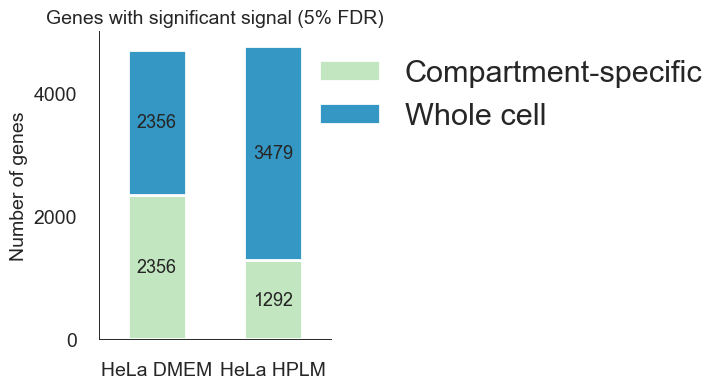

In [7]:
# Plot hits summary for Fig 3A
mpl.rc('axes', linewidth=0.7)
mpl.rc('xtick', labelsize=14)
mpl.rc('xtick', labelsize=14)

fig, ax = plt.subplots(figsize=(3,4))
colors = sns.color_palette('GnBu')[:8]
hits_plot = pd.DataFrame({'Compartment-specific': [len(comp_spec_hits_DMEM), len(comp_spec_hits_HPLM)],
                         'Whole cell': [len(whole_cell_hits_DMEM),len(whole_cell_hits_HPLM)]},
                        index=['HeLa DMEM','HeLa HPLM'])

hits_plot.plot(kind='bar', 
               stacked=True,
               color=[colors[1], colors[4]],
               legend = 'reverse',
               rot = 0,
               fontsize= 14,
               width = 0.5,
               ax=ax)

ax.set_title('Genes with significant signal (5% FDR)',size=14) #Genes with significant signal above noise
ax.set_ylabel('Number of genes',size=14)

ax.bar_label(ax.containers[0],label_type='center',size=13)
ax.bar_label(ax.containers[1],label_type='center',size=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc="upper left", bbox_to_anchor=(0.83,1),frameon=False, ncol=1)
fig.savefig(os.path.join(output_folder,'figure_panels','Fig3A_HeLa_DMEM_HPLM_whole_cell_compartment_specific_hits.png'),dpi = 300,bbox_inches='tight')

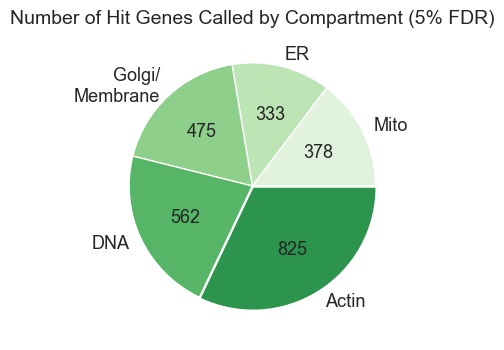

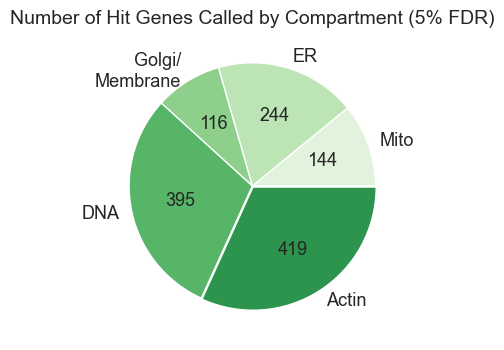

In [8]:
# Plot hits summary for Fig 3B
def absolute_value2(val):
    a  = data[np.abs(data - val/100.*sum(data)).argmin() ]
    return a

for (df, condition) in [(comp_spec_hits_DMEM,'DMEM'),(comp_spec_hits_HPLM,'HPLM')]:
        labels = ['Mito','ER','Golgi/\nMembrane','DNA','Actin']
        mito_5 = threshold_dict[condition]['Mito']
        cona_5 = threshold_dict[condition]['ConA']
        wga_5 = threshold_dict[condition]['WGA']
        dapi_5 = threshold_dict[condition]['DAPI']
        phal_5 = threshold_dict[condition]['Phalloidin']
        data = [len(df.query('Mito > @mito_5 & Sum <= @sum_5')),
                len(df.query('ConA > @cona_5 & Sum <= @sum_5')),
                len(df.query('WGA > @wga_5 & Sum <= @sum_5')),
                len(df.query('DAPI > @dapi_5 & Sum <= @sum_5')),
                len(df.query('Phalloidin > @phal_5 & Sum <= @sum_5'))]
        colors = sns.color_palette('Greens')[:5]    
        fig, ax = plt.subplots(figsize=(7,4))

        sns.set_theme(style='white',palette='RdBu')
        plt.pie(data,
                labels=labels,
                autopct=absolute_value2,
                colors=colors,
                textprops={'fontsize': 13},
                explode=(0.0, 0.0, 0.0, 0.0, 0.01))
        ax.set_title('Number of Hit Genes Called by Compartment (5% FDR)',size=14)
        fig.savefig(os.path.join(output_folder,'figure_panels',f'Fig3B_HeLa_{condition}_compartment_specific_hits_distribution.png'),dpi = 300,bbox_inches='tight')

# Figure 3C

In [9]:
# Directly load hit lists to bypass running Figure 3A/B
#whole_cell_hits_DMEM = pd.read_csv(os.path.join(output_folder,'HeLa_DMEM_plate_level_median_per_feat_sig_genes_5_FDR_whole_cell_hits.csv')).set_index('Gene')
#comp_spec_hits_DMEM = pd.read_csv(os.path.join(output_folder,'HeLa_DMEM_plate_level_median_per_feat_sig_genes_5_FDR_compartment_specific_hits.csv')).set_index('Gene')
#whole_cell_hits_HPLM = pd.read_csv(os.path.join(output_folder,'HeLa_DMEM_plate_level_median_per_feat_sig_genes_5_FDR_whole_cell_hits.csv')).set_index('Gene')
#comp_spec_hits_HPLM = pd.read_csv(os.path.join(output_folder,'HeLa_DMEM_plate_level_median_per_feat_sig_genes_5_FDR_compartment_specific_hits.csv')).set_index('Gene')

In [10]:
hit_list_DMEM = list(comp_spec_hits_DMEM.index) + list(whole_cell_hits_DMEM.index)
df_hits_DMEM = df_gene_DMEM.loc[df_gene_DMEM.index.isin(hit_list_DMEM)]
hit_list_HPLM = list(comp_spec_hits_HPLM.index) + list(whole_cell_hits_HPLM.index)
df_hits_HPLM = df_gene_HPLM.loc[df_gene_HPLM.index.isin(hit_list_HPLM)]

# Perform principal component analysis on hit lists
df_hits_pca_dict = {}
for (df_hits, condition) in [(df_hits_DMEM, 'DMEM'), (df_hits_HPLM, 'HPLM')]:
    pca = PCA()
    pca.fit(df_hits)
    x = list(pca.explained_variance_ratio_)
    # Find principal component that represents 70% variation
    PCA_lookup = {}
    for i in range(len(x)):
        distance = abs(.7-sum(x[:i+1]))
        PCA_lookup[distance] = i 
    component = PCA_lookup[min(PCA_lookup.keys())]+1
    print (f'For {condition}, principal component representing closest to 70% variation is {component}')
    # Perform principal component analysis and select components representing 70% of variation in data
    pca = PCA(n_components=component)
    df_hits_pca = pd.DataFrame(pca.fit_transform(df_hits),index=df_hits.index)
    df_hits_pca_dict[condition] = df_hits_pca
    df_hits_pca.head()
    df_hits_pca.to_csv(os.path.join(output_folder,f'HeLa_{condition}_hit_list_PCA.csv'))

For DMEM, principal component representing closest to 70% variation is 78
For HPLM, principal component representing closest to 70% variation is 49


Overall number of paired correlations for DMEM is 11099116
For condition DMEM 
 hit set is 1663, cluster count is 871, hit cluster list is 871
For condition DMEM 
 Number of hit pairs is 6168 
 Number of hit pairs with correlation is 6167


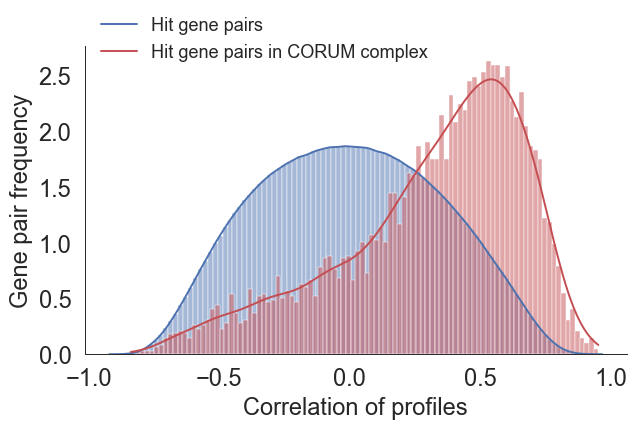

Overall number of paired correlations for HPLM is 11378835
For condition HPLM 
 hit set is 1604, cluster count is 799, hit cluster list is 799
For condition HPLM 
 Number of hit pairs is 4801 
 Number of hit pairs with correlation is 4798


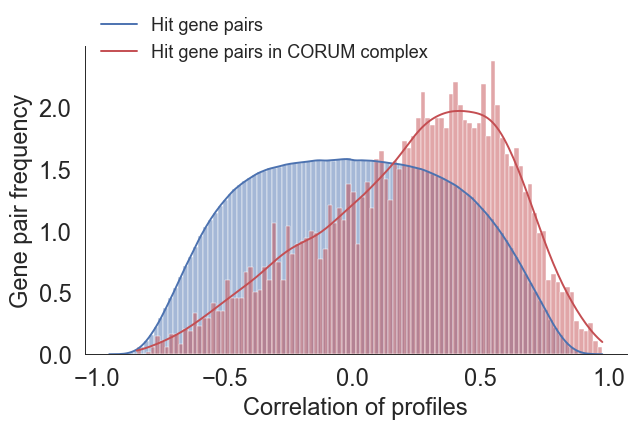

In [11]:
# Calculate correlation between all gene pairs and create a dictionary of gene pairs/correlation
parent_corr_dic = {}
for (df_hits, condition) in [(df_hits_pca_dict['DMEM'], 'DMEM'), (df_hits_pca_dict['HPLM'], 'HPLM')]:
    df_hits_corr = df_hits.T.corr()
    genes = list(df_hits_corr.index)
    corr_dic = {}
    for gene1 in genes:
        for gene2 in genes:
            if len(frozenset([gene1,gene2])) == 1 :
                continue
            else:    
                corr_dic[frozenset([gene1,gene2])]=(df_hits_corr.loc[gene1,gene2])
    parent_corr_dic[condition] = corr_dic
    print (f'Overall number of paired correlations for {condition} is {len(corr_dic)}')

    # Create a list of protein clusters with all complexes that had at least 66% of genes represented within the hits
    cluster_count = 0
    hit_cluster_list_list = []
    hit_set = set()
    for i in range(len(ppi_data)):
        cluster = ppi_data.iloc[i]['subunits(Gene name)'].split(';')
        count = 0
        hit_cluster_list = []
        for g in cluster:
            if g in genes:
                count += 1
                hit_set.add(g)
                hit_cluster_list.append(g)
        if (count/len(cluster)) >= 0.66:
            cluster_count += 1
        if hit_cluster_list and (count/len(cluster)) >= 0.66:
            hit_cluster_list_list.append(hit_cluster_list)
    print(f'For condition {condition} \n hit set is {len(hit_set)}, cluster count is {cluster_count}, hit cluster list is {len(hit_cluster_list_list)}')

    # Assign correlations to hit gene pairs
    hit_pair_set = set()
    for l in hit_cluster_list_list:
        for c in list(permutations(l,2)):
            hit_pair_set.add(frozenset(c))

    hit_corr_dic = {}
    for s in hit_pair_set:
        if len(s) != 1:
            hit_corr_dic[s] = corr_dic[s]

    print(f'For condition {condition} \n Number of hit pairs is {len(hit_pair_set)} \n',
        f'Number of hit pairs with correlation is {len(hit_corr_dic)}')
    
    # Plot CORUM gene pair correlation distribution for Fig 3C
    sns.set_theme(style="white",rc = {'axes.linewidth': 0.7,'xtick.labelsize':17,'ytick.labelsize':17})
    fig, ax = plt.subplots(figsize=(7,4))
    all_corr = list(corr_dic.values())
    cluster_corr = list(hit_corr_dic.values())

    sns.histplot(all_corr ,color='b' ,stat= 'percent' ,bins= 100, kde=True, line_kws={'lw':1.4} , alpha=0.5,ax = ax);
    sns.histplot(cluster_corr ,color='r' ,stat= 'percent' ,bins= 100, kde=True, line_kws={'lw':1.4} ,alpha=0.5,ax = ax);

    ax.set_ylabel('Gene pair frequency',size=17)
    ax.set_xlabel('Correlation of profiles',size=17)
    font = font_manager.FontProperties(size=13)
    ax.legend(['Hit gene pairs','Hit gene pairs in CORUM complex'],loc='upper left',bbox_to_anchor=(0.0,1.15),frameon=False,prop=font )
    sns.despine(top = True)

    fig.savefig(os.path.join(output_folder,'figure_panels',f'Fig3C_HeLa_{condition}_CORUM_gene_pair_correlation_distribution.png'), dpi=300,facecolor='w', edgecolor='w', bbox_inches='tight')
    plt.show()

# Figure 3D

Minimum correlation for DMEM is -0.9206642193167176
Maximum correlation for DMEM is 0.9683710621661668


/opt/anaconda3/envs/periscope_2022/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator


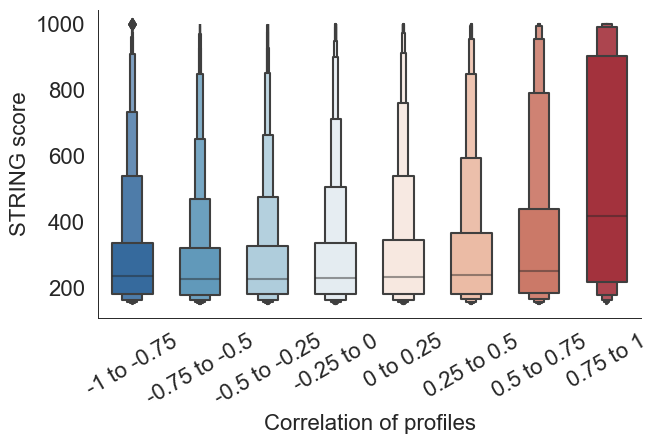

Minimum correlation for HPLM is -0.9511843117062427
Maximum correlation for HPLM is 0.9768062648636825


/opt/anaconda3/envs/periscope_2022/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator


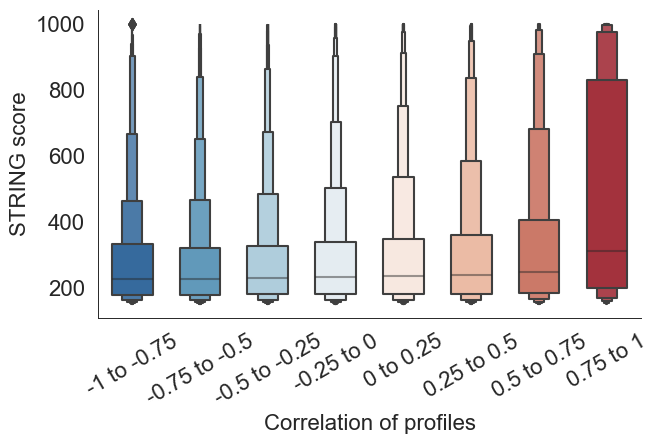

In [12]:
for (df_hits, condition) in [(df_hits_DMEM, 'DMEM'), (df_hits_HPLM, 'HPLM')]:
    # Subset the STRING predicted protein links to HeLa WGS hits
    genes = list(df_hits.index)
    ppi_data_name_hits = STRING_data[STRING_data['protein1'].isin(genes) & STRING_data['protein2'].isin(genes)]

    # Determine min, max
    print(f'Minimum correlation for {condition} is {min(parent_corr_dic[condition].values())}')
    print(f'Maximum correlation for {condition} is {max(parent_corr_dic[condition].values())}')

    # Bin the correlations into 8 categories 
    results = ppi_data_name_hits.copy(deep=True).reset_index(drop=True)

    bins = [-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]
    for i in range(len(results)):
        gene1 = results.iloc[i]['protein1']
        gene2 = results.iloc[i]['protein2']
        corr_value = parent_corr_dic[condition][frozenset([gene1,gene2])]
        results.at[i , 'correlation'] = corr_value
        if corr_value > bins[7]:
            results.at[i , 'correlation_bin'] = f'{bins[7]} to {bins[8]}'
        elif corr_value > bins[6] and corr_value <= bins[7]:
            results.at[i , 'correlation_bin'] = f'{bins[6]} to {bins[7]}'
        elif corr_value > bins[5] and corr_value <= bins[6]:
            results.at[i , 'correlation_bin'] = f'{bins[5]} to {bins[6]}'
        elif corr_value > bins[4] and corr_value <= bins[5]:
            results.at[i , 'correlation_bin'] = f'{bins[4]} to {bins[5]}'
        elif corr_value > bins[3] and corr_value <= bins[4]:
            results.at[i , 'correlation_bin'] = f'{bins[3]} to {bins[4]}'
        elif corr_value > bins[2] and corr_value <= bins[3]:
            results.at[i , 'correlation_bin'] = f'{bins[2]} to {bins[3]}'
        elif corr_value > bins[1] and corr_value <= bins[2]:
            results.at[i , 'correlation_bin'] = f'{bins[1]} to {bins[2]}'
        elif corr_value <= bins[1]:
            results.at[i , 'correlation_bin'] = f'{bins[0]} to {bins[1]}'
    
    # Plot STRING score X gene pair correlation for Fig 3D
    sns.set_theme(style="white",rc = {'axes.linewidth': 0.7})

    fig, ax = plt.subplots(figsize=(7,4))
    order = [f'{bins[0]} to {bins[1]}',f'{bins[1]} to {bins[2]}',f'{bins[2]} to {bins[3]}',f'{bins[3]} to {bins[4]}',f'{bins[4]} to {bins[5]}',f'{bins[5]} to {bins[6]}',f'{bins[6]} to {bins[7]}',f'{bins[7]} to {bins[8]}']

    flierprops = dict(markerfacecolor='white', markersize=0.1, linestyle='none')
    sns.boxenplot(data=results,
                x = 'correlation_bin',
                y = 'combined_score', 
                order=order, 
                width = 0.6,
                palette = 'RdBu_r',
                ax=ax)

    ax.set_xlabel('Correlation of profiles',size=16)
    ax.set_ylabel('STRING score',size=16)
    ax.tick_params(axis='both', which='major', labelsize=14)

    labels = [item for item in ax.get_yticks()]
    ax.set_yticklabels([str(round(float(label))) for label in labels], size=16)
    ax.set_xticklabels(order, size=16,rotation=30)

    sns.despine(top = True,left=False,bottom=False)

    fig.savefig(os.path.join(output_folder,'figure_panels',f'Fig3D_HeLa_{condition}_STRING_gene_pair_correlation_score.png'), 
                dpi=300,
                facecolor='w', 
                edgecolor='w', 
                bbox_inches='tight')
    plt.show()

# Figures 3E and 3F

For DMEM label length is 2356
For HPLM label length is 1292


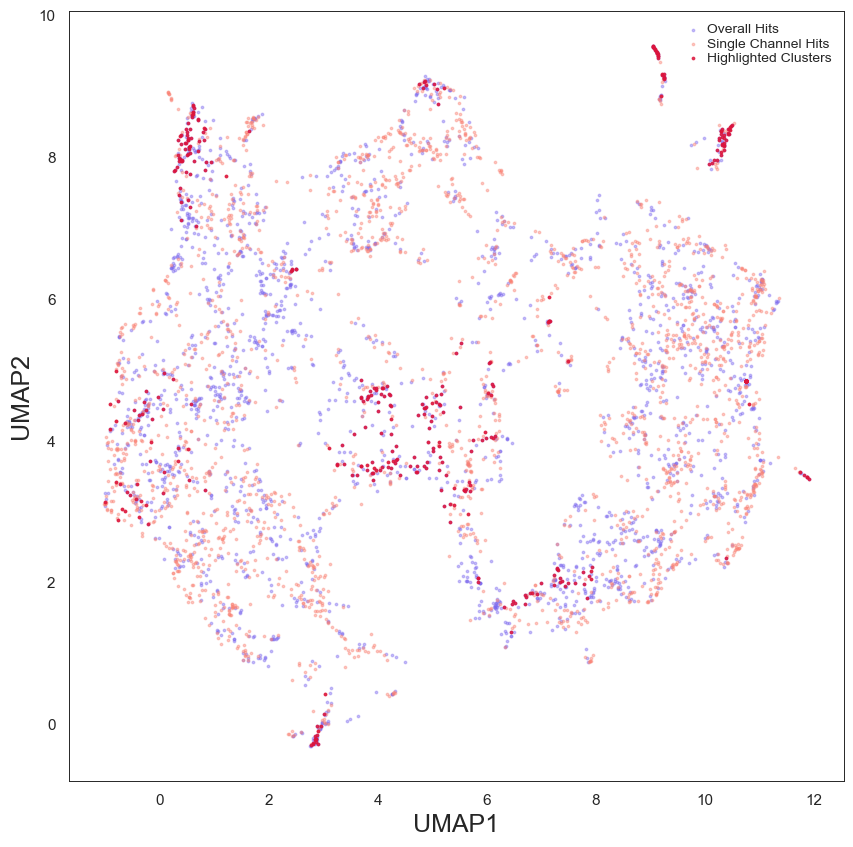

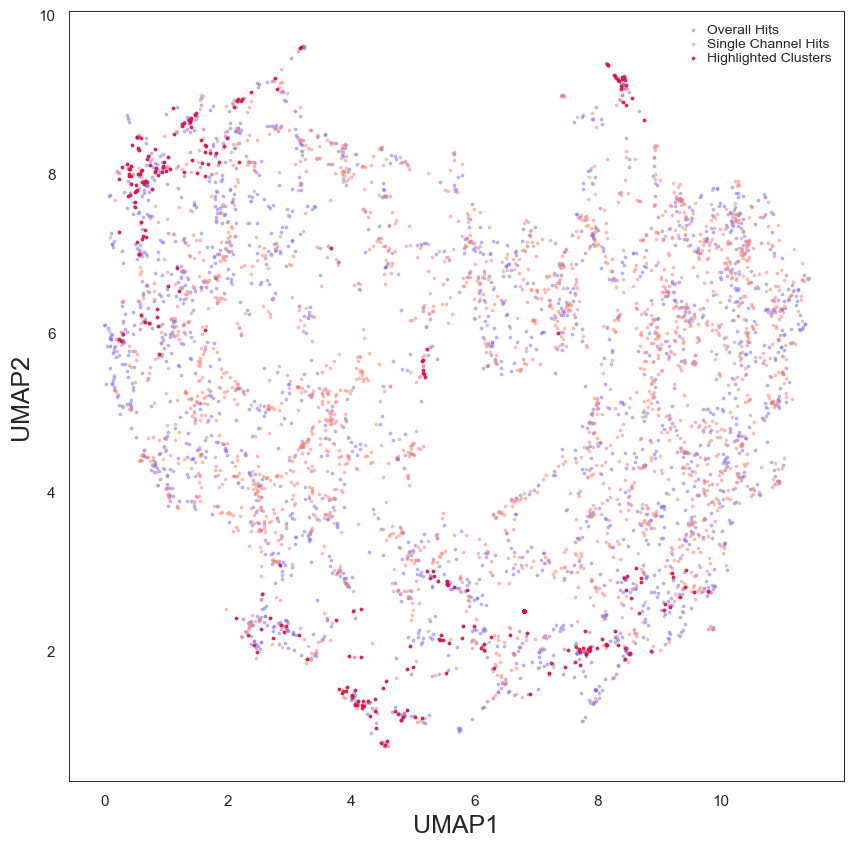

In [13]:
for (df_hits_pca, whole_cell_hits, hit_list, condition) in [(df_hits_pca_dict['DMEM'], whole_cell_hits_DMEM, hit_list_DMEM,'DMEM'), (df_hits_pca_dict['HPLM'],  whole_cell_hits_HPLM, hit_list_HPLM,'HPLM')]:
    # Perform UMAP dimensionality reduction
    clusterable_embedding = umap.UMAP(
        n_neighbors=4,
        min_dist=0.04,
        n_components=2,
        random_state=43,
        metric = 'cosine',
    ).fit_transform(df_hits_pca)

    # Manually label highlighted hits  
    overall_labels = [list(df_hits_pca.index).index(i) if i in list(whole_cell_hits.index) else -1 for i in hit_list]
    other_labels = [list(df_hits_pca.index).index(i) if i not in list(whole_cell_hits.index) else -1 for i in hit_list]
    
    if condition == 'DMEM':
        highlight_categories = ['MITOCHONDRIAL_MATRIX','DNA_REPLICATION','RIBOSOME_BIOGENESIS','MANNOSYLATION','PROTON_TRANSPORTING_TWO_SECTOR_ATPASE_COMPLEX','GOLGI_VESICLE_TRANSPORT','ARP2_3_COMPLEX_MEDIATED_ACTIN_NUCLEATION','PROTEIN_N_LINKED_GLYCOSYLATION','ENZYME_LINKED_RECEPTOR_PROTEIN_SIGNALING_PATHWAY','TRICARBOXYLIC_ACID_CYCLE','MITOTIC_CELL_CYCLE']
        highlight_list = []
        for x in highlight_categories:
            highlight_list += gene_set_dict[f"{x}_DMEM_CLUSTER"]
    if condition == 'HPLM':
        highlight_categories = ['GOLGI_VESICLE_TRANSPORT','PROTEIN_N_LINKED_GLYCOSYLATION','DNA_REPLICATION','RIBOSOME_BIOGENESIS','PROTON_TRANSPORTING_TWO_SECTOR_ATPASE_COMPLEX','LAMELLIPODIUM','AEROBIC_RESPIRATION','TRANSFERASE_COMPLEX','MITOCHONDRIAL_MATRIX','MITOTIC_CELL_CYCLE']
        highlight_list = []
        for x in highlight_categories:
            highlight_list += gene_set_dict[f"{x}_HPLM_CLUSTER"]
    highlight_labels = [list(df_hits_pca.index).index(i) if i in highlight_list else -1 for i in hit_list]
    print (f'For {condition} label length is {len(overall_labels)-other_labels.count(-1)}')
    
    '''
    # Save the coordinates/additional information from the UMAP ***note: Activate/Un comment this section if you wish to freeze the UMAP version ***
    clusterable_embedding_x, clusterable_embedding_y = np.split(clusterable_embedding,2,axis=1)
    clusterable_embedding_x_list = clusterable_embedding_x.tolist()
    clusterable_embedding_y_list = clusterable_embedding_y.tolist()
    umap_dic = {
        f'{condition}_overall_labels':(overall_labels),
        f'{condition}_other_labels':(other_labels),
        f'{condition}_highlight_labels':(highlight_labels),
        f'{condition}_clusterable_embedding_x':(clusterable_embedding_x_list),
        f'{condition}_clusterable_embedding_y':(clusterable_embedding_y_list),
        f'{condition}_gene_names':(list(df_hits_pca.index))
    }
    umap_json = json.dumps(umap_dic)

    with open(f"inputs/{condition}_umap_frozen_version.json", "w") as f:
        f.write(umap_json)
    '''
    
    # Load the frozen version of the UMAP data from the figure *** note: Deactivate/comment out this section if you wish to redraw the UMAP ***
    with open(f"inputs/{condition}_umap_frozen_version.json") as f:
        umap_json = json.load(f)

    clusterable_embedding_x_list = umap_json[f'{condition}_clusterable_embedding_x']
    clusterable_embedding_y_list = umap_json[f'{condition}_clusterable_embedding_y']
    clusterable_embedding_x = np.asanyarray(clusterable_embedding_x_list,dtype='float32')
    clusterable_embedding_y = np.asanyarray(clusterable_embedding_y_list,dtype='float32')
    clusterable_embedding = np.column_stack((clusterable_embedding_x, clusterable_embedding_y))
    overall_labels = umap_json[f'{condition}_overall_labels']
    other_labels = umap_json[f'{condition}_other_labels']
    highlight_labels = umap_json[f'{condition}_highlight_labels']
    gene_names_with_order = umap_json[f'{condition}_gene_names']

    # Plot the data and color code based on the type of hit.
    plt.figure(figsize=(10, 10))
    plt.scatter(clusterable_embedding[overall_labels, 0],
                clusterable_embedding[overall_labels, 1],
                c='mediumslateblue',
                s=3,
                alpha=0.4,
            );
    plt.scatter(clusterable_embedding[other_labels, 0],
                clusterable_embedding[other_labels, 1],
                c='salmon',
                s=3,
                alpha=0.4,
            );
    plt.scatter(clusterable_embedding[highlight_labels, 0],
                clusterable_embedding[highlight_labels, 1],
                c='crimson',
                s=3,
                alpha=0.8,
            );
    plt.xlabel('UMAP1',fontsize=18)
    plt.ylabel('UMAP2',fontsize=18)
    plt.legend(labels=['Overall Hits','Single Channel Hits','Highlighted Clusters'],loc="upper right",bbox_to_anchor=(1,1), frameon=False, ncol=1,fontsize=10 ,labelspacing=0.1,handletextpad=0)# 

    plt.savefig(os.path.join(output_folder,'figure_panels',f'Fig3EF_HeLa_{condition}_UMAP_clustering.png'),bbox_inches='tight', dpi=600,facecolor='w', edgecolor='w')

# Figures 3G and 3H

In [14]:
def coupled_heatmap(profile_df_1,profile_df_2,gene_set,genes,naming,font_scale = 3.5):
    # Clustered based on the profile_df_1 arm first
    df1_genes_df =  profile_df_1.loc[profile_df_1.index.isin(genes)]
    
    # Clustered based on the profile_df_1 arm first
    data = df1_genes_df.T
    corr = data.corr()

    ax = sns.clustermap(
        corr, 
        vmin=-1, vmax=1, center=0,
        method = 'ward',
    )

    # Clustered based on the profile_df_1 arm first
    df1_gene_list = list(df1_genes_df.index)

    df1_cluster_order = ax.dendrogram_row.reordered_ind
    df1_cluster_list = [df1_gene_list[i] for i in df1_cluster_order]

    df2_gene_df =  profile_df_2.loc[profile_df_2.index.isin(df1_cluster_list)]
    df2_gene_profiles = df2_gene_df.reindex(df1_cluster_list)
    df1_gene_profiles = df1_genes_df.reindex(df1_cluster_list)

    df1_data = df1_gene_profiles.T
    df1_corr = df1_data.corr()

    df2_data = df2_gene_profiles.T
    df2_corr = df2_data.corr()
    corr = df2_corr.copy()
    for i in range(len(df1_corr)):
        for j in range(len(df1_corr)):
            if i > j:
                corr.iat[i,j] = df1_corr.iat[i,j]
            elif i < j:
                corr.iat[i,j] = df2_corr.iat[i,j]
            elif i == j:
                corr.iat[i,j] = 1

    plt.clf()
    fig, ax = plt.subplots(figsize=(30, 30))
    sns.set(font_scale=font_scale,rc={'figure.figsize':(30,30)})

    ax = sns.heatmap(
                corr, 
                vmin=-1, vmax=1, center=0,
                cmap=sns.diverging_palette(250, 10 ,s=100,l=35, n=100),
                linewidth = 1,
                linecolor='white',
                cbar=False,
                cbar_kws={"shrink": .76}
    )
    ax.set_xticklabels(
                ax.get_xticklabels(),
                rotation=90,
                horizontalalignment='right'
    )
    ax.yaxis.tick_right()
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='left')
    ax.set_xlabel("")
    ax.set_ylabel("")

    plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(output_folder,'figure_panels', f'Fig3GH_HeLa_median_plate_level_profile_heatmap_clustering_gene_hits_{gene_set}_{naming}.png'),dpi=300)

<Figure size 1000x1000 with 0 Axes>

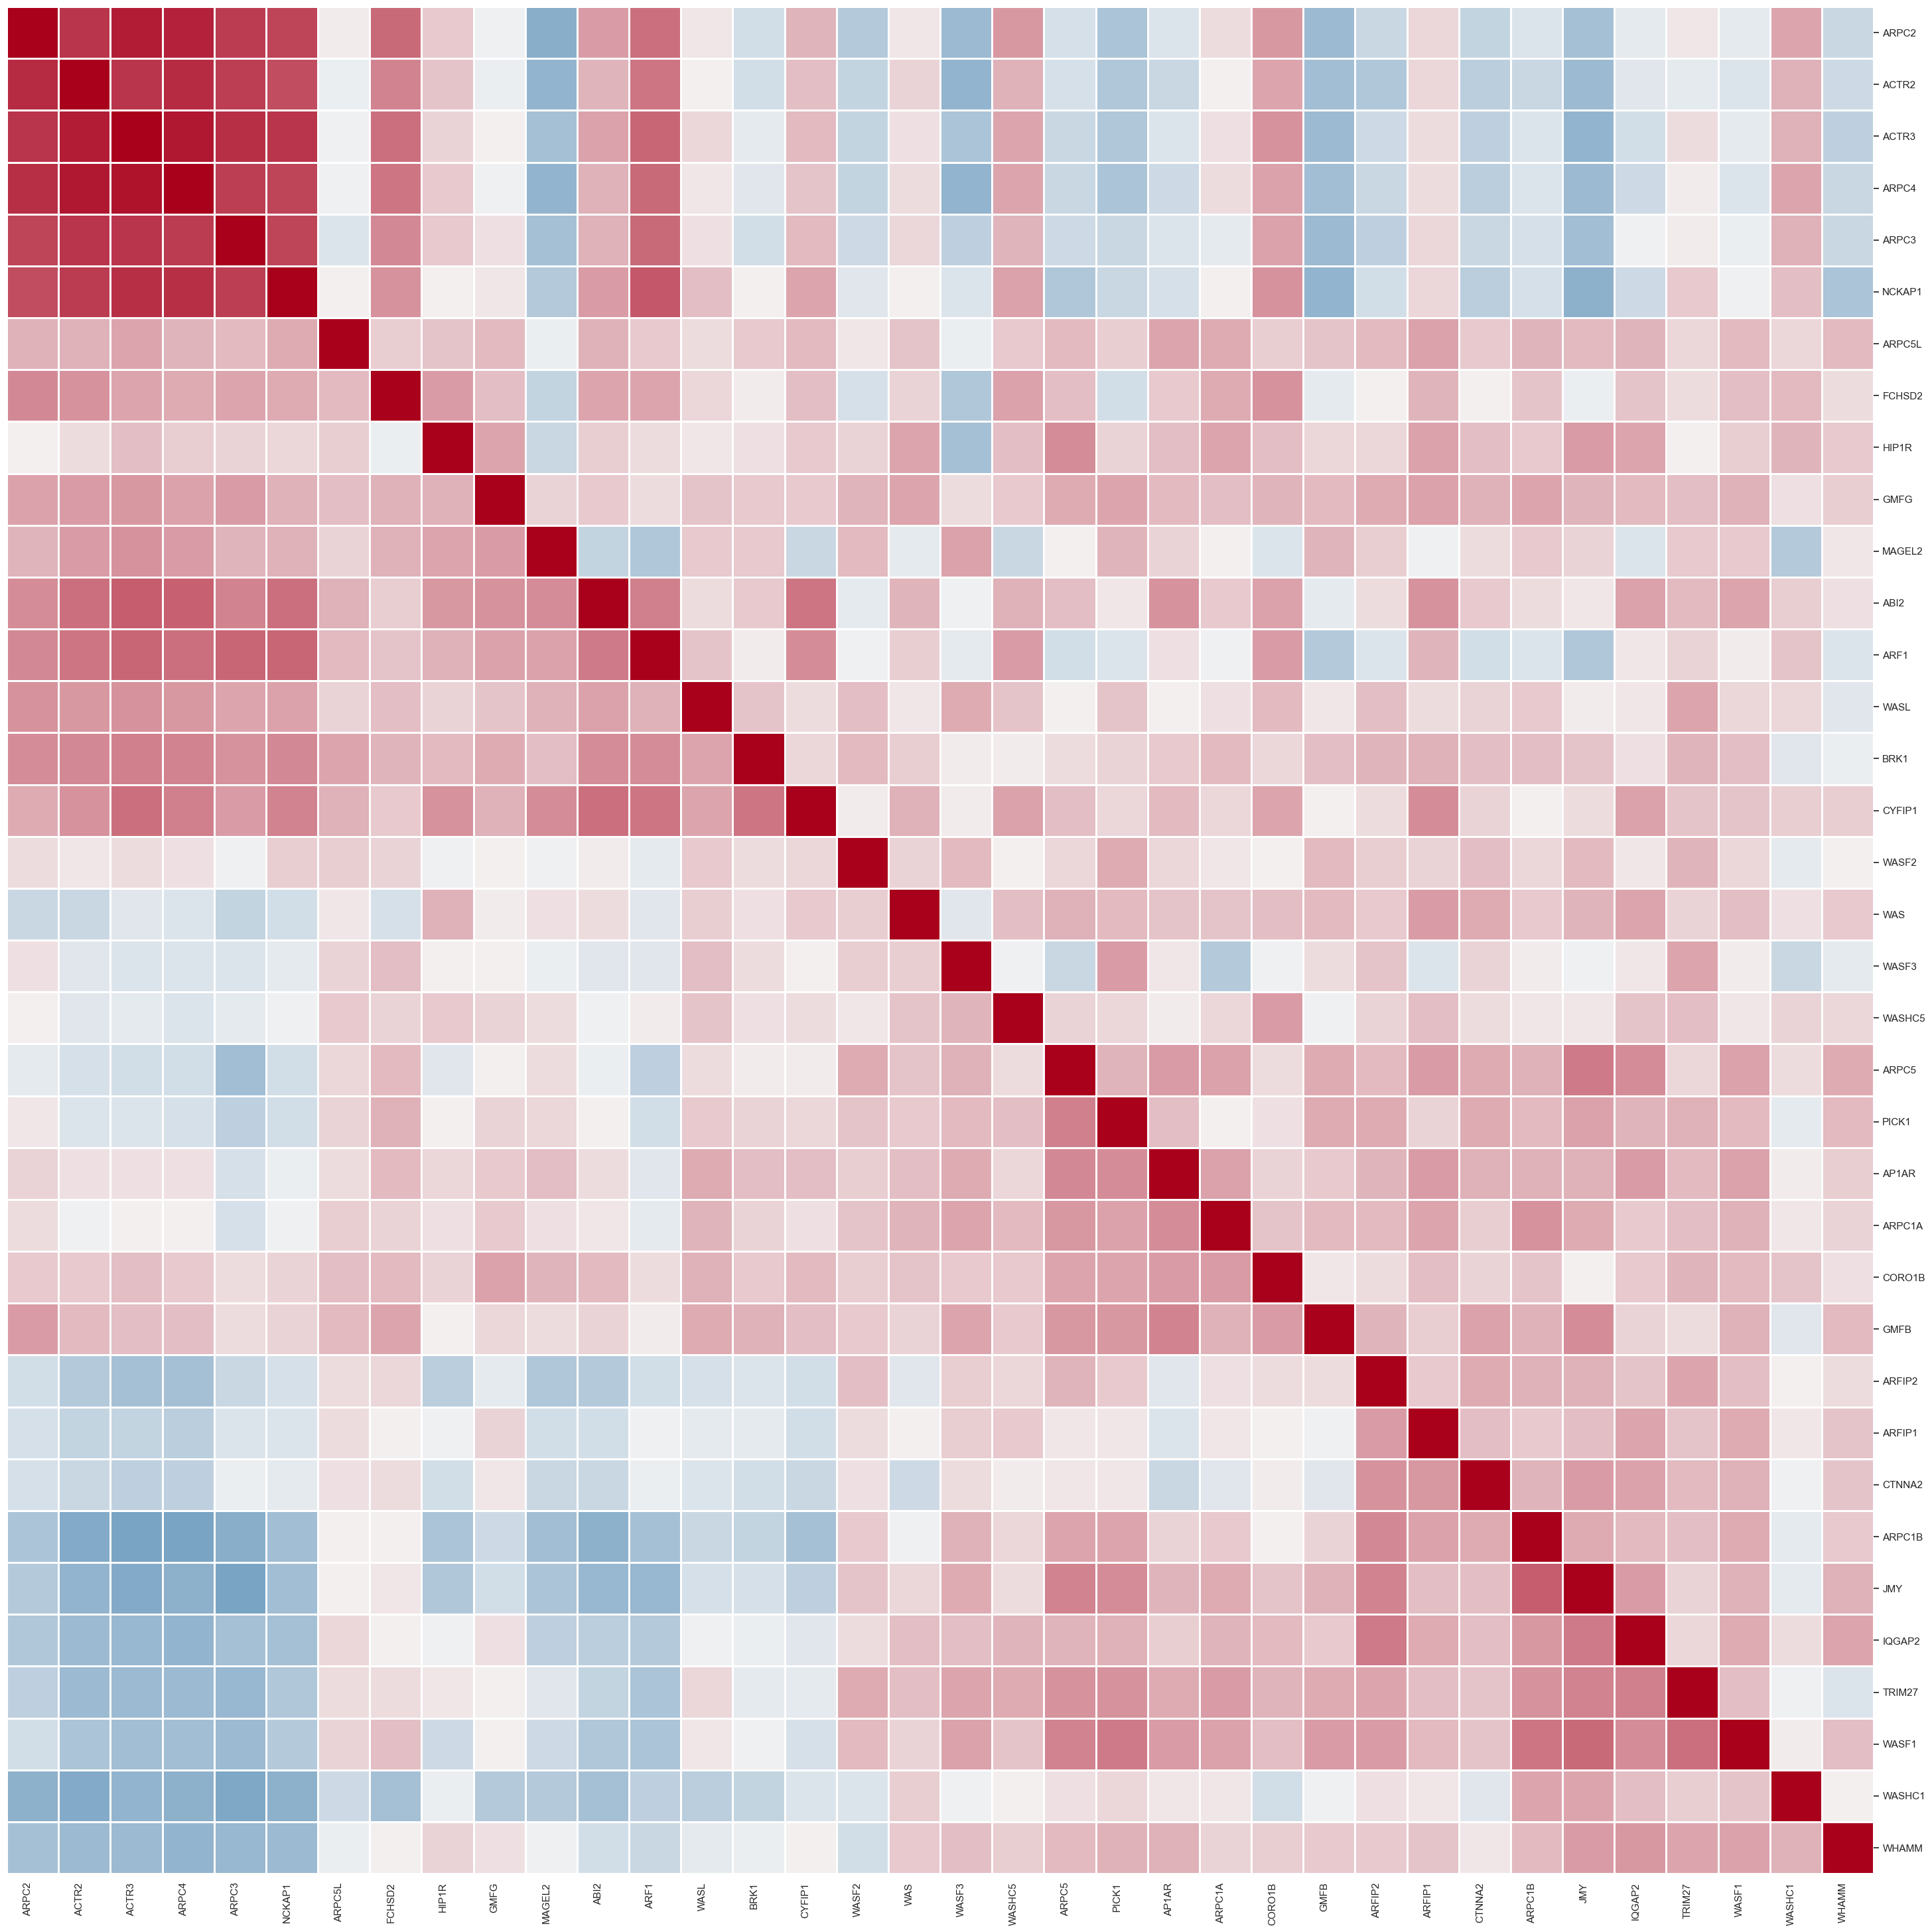

In [15]:
# Clustered based on the HPLM arm first
gene_set = 'ARP2_3_COMPLEX_MEDIATED_ACTIN_NUCLEATION'
genes = gene_set_dict[gene_set]
coupled_heatmap(df_gene_HPLM,df_gene_DMEM,gene_set,genes,'HPLM_first',3)

<Figure size 1000x1000 with 0 Axes>

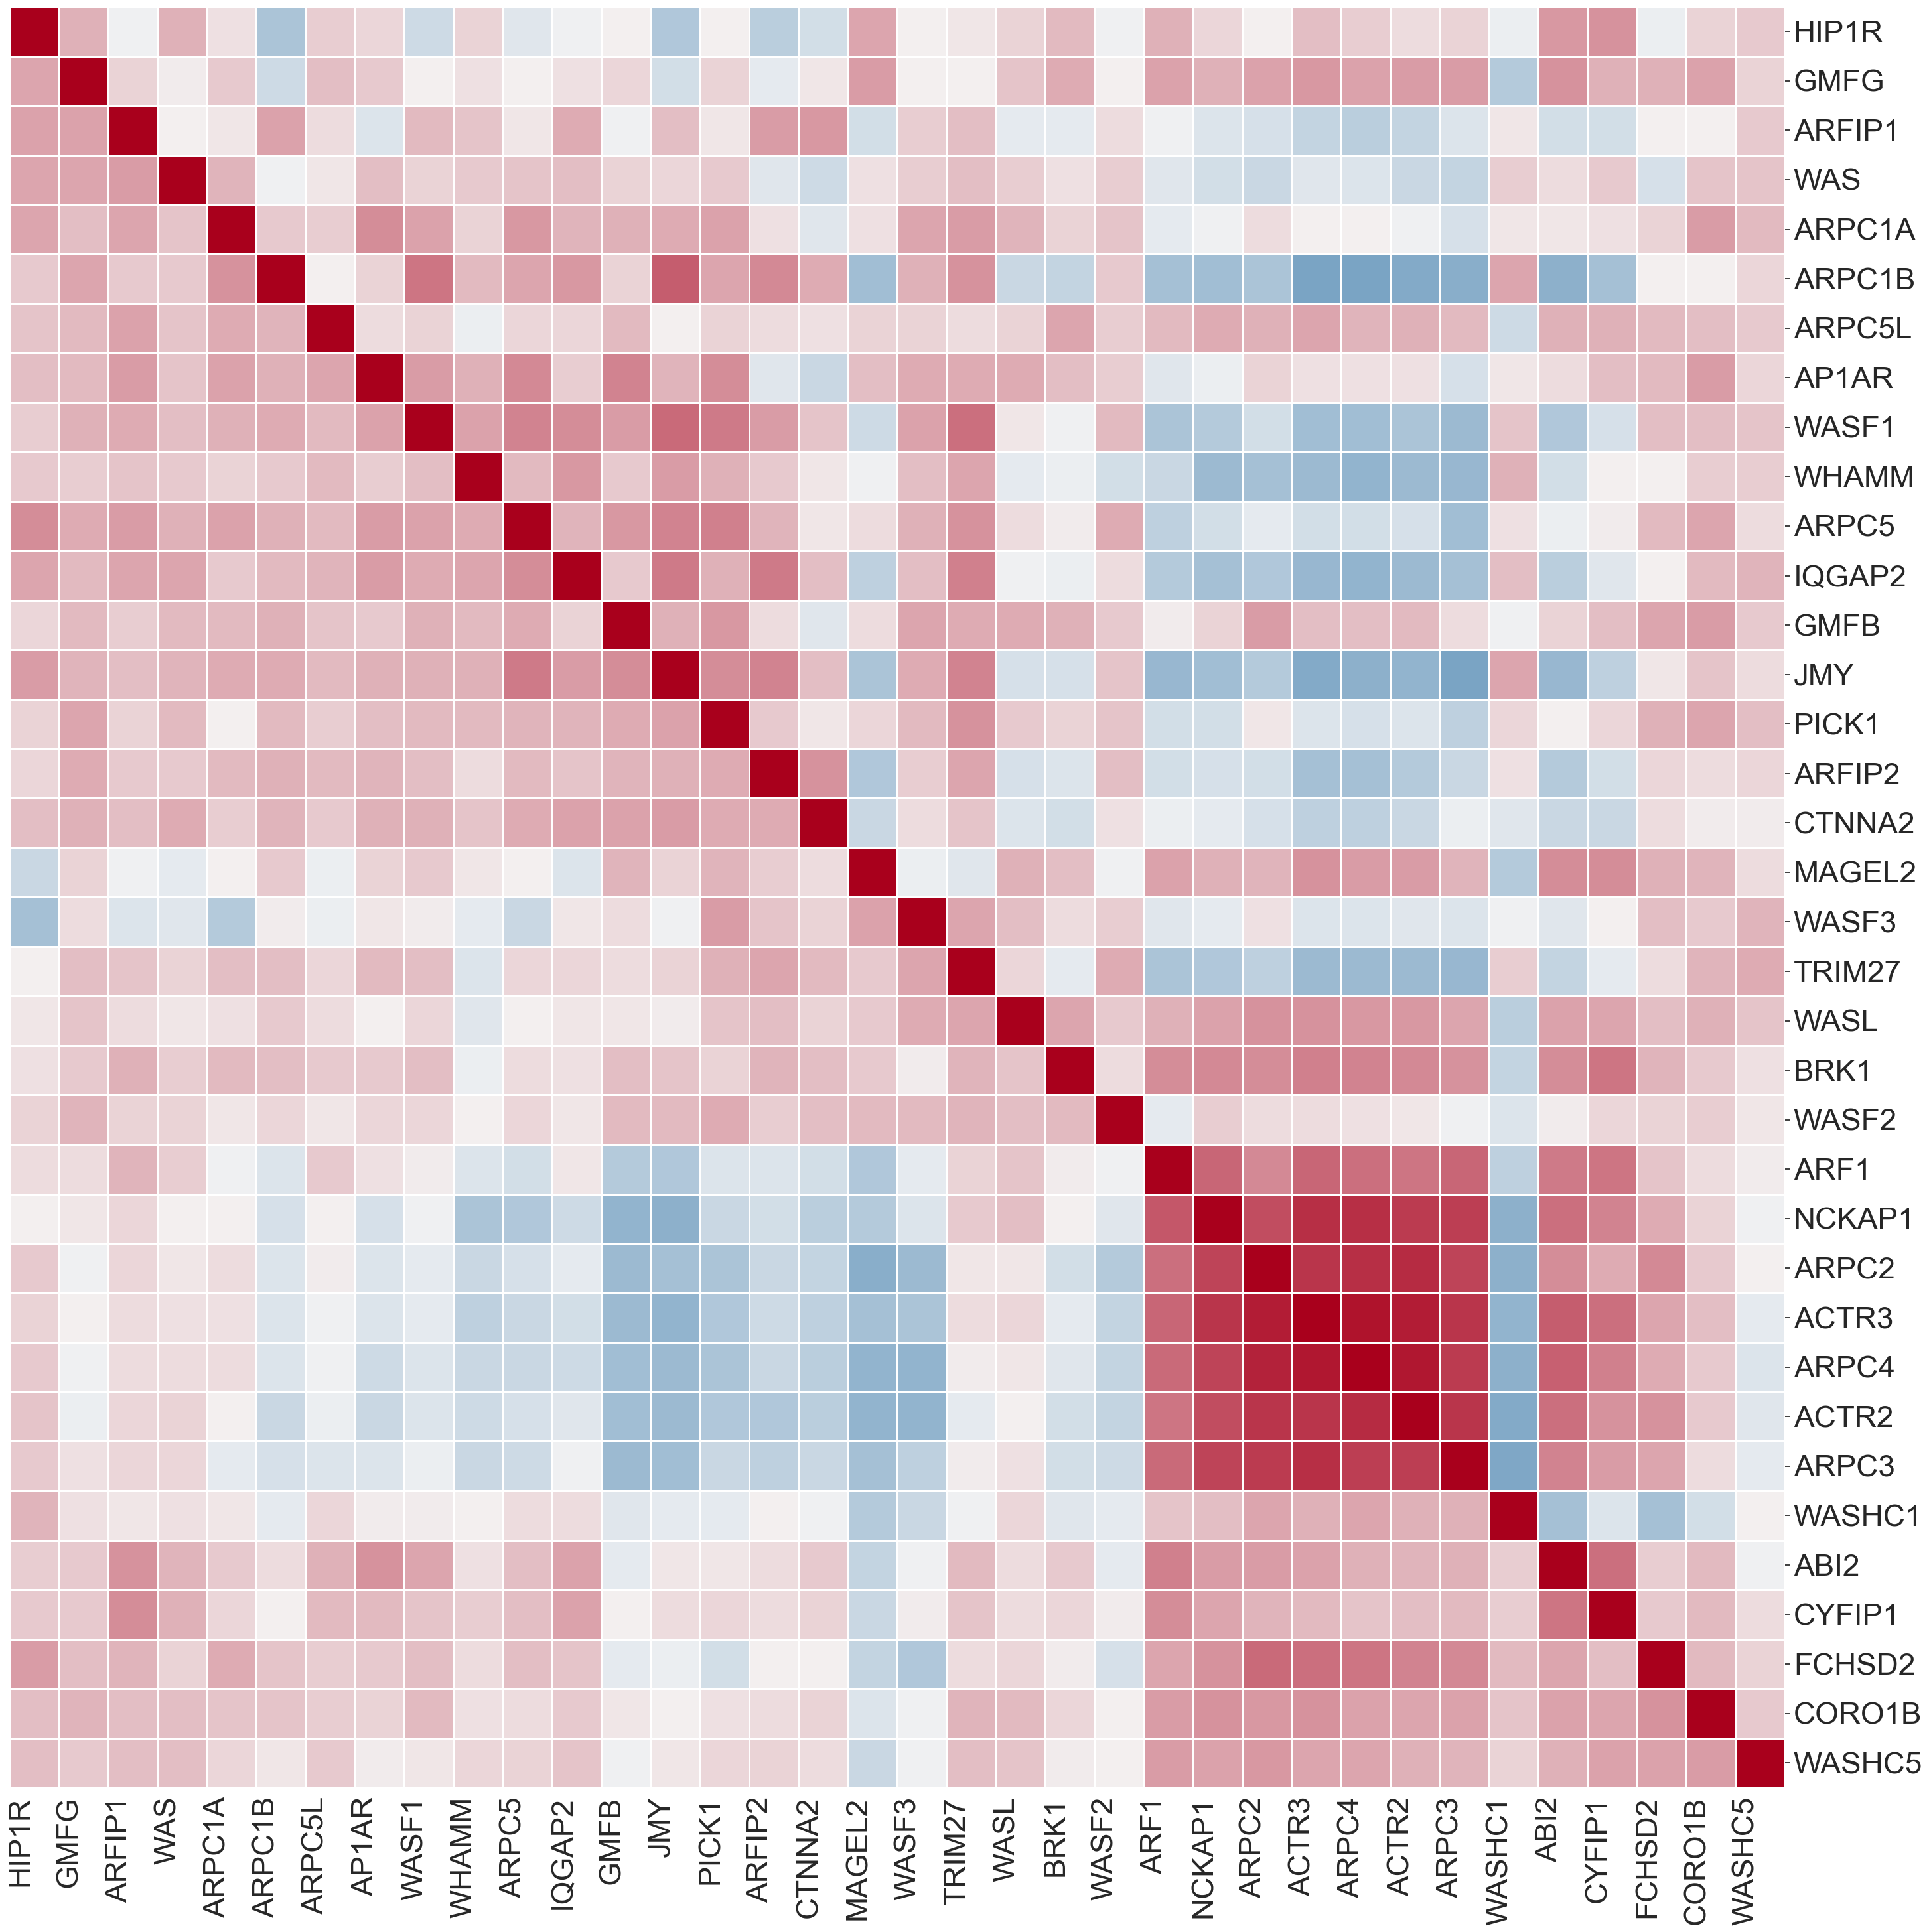

In [16]:
# Clustered based on the DMEM arm first
coupled_heatmap(df_gene_DMEM,df_gene_HPLM,gene_set,genes,'DMEM_first',3)

<Figure size 1000x1000 with 0 Axes>

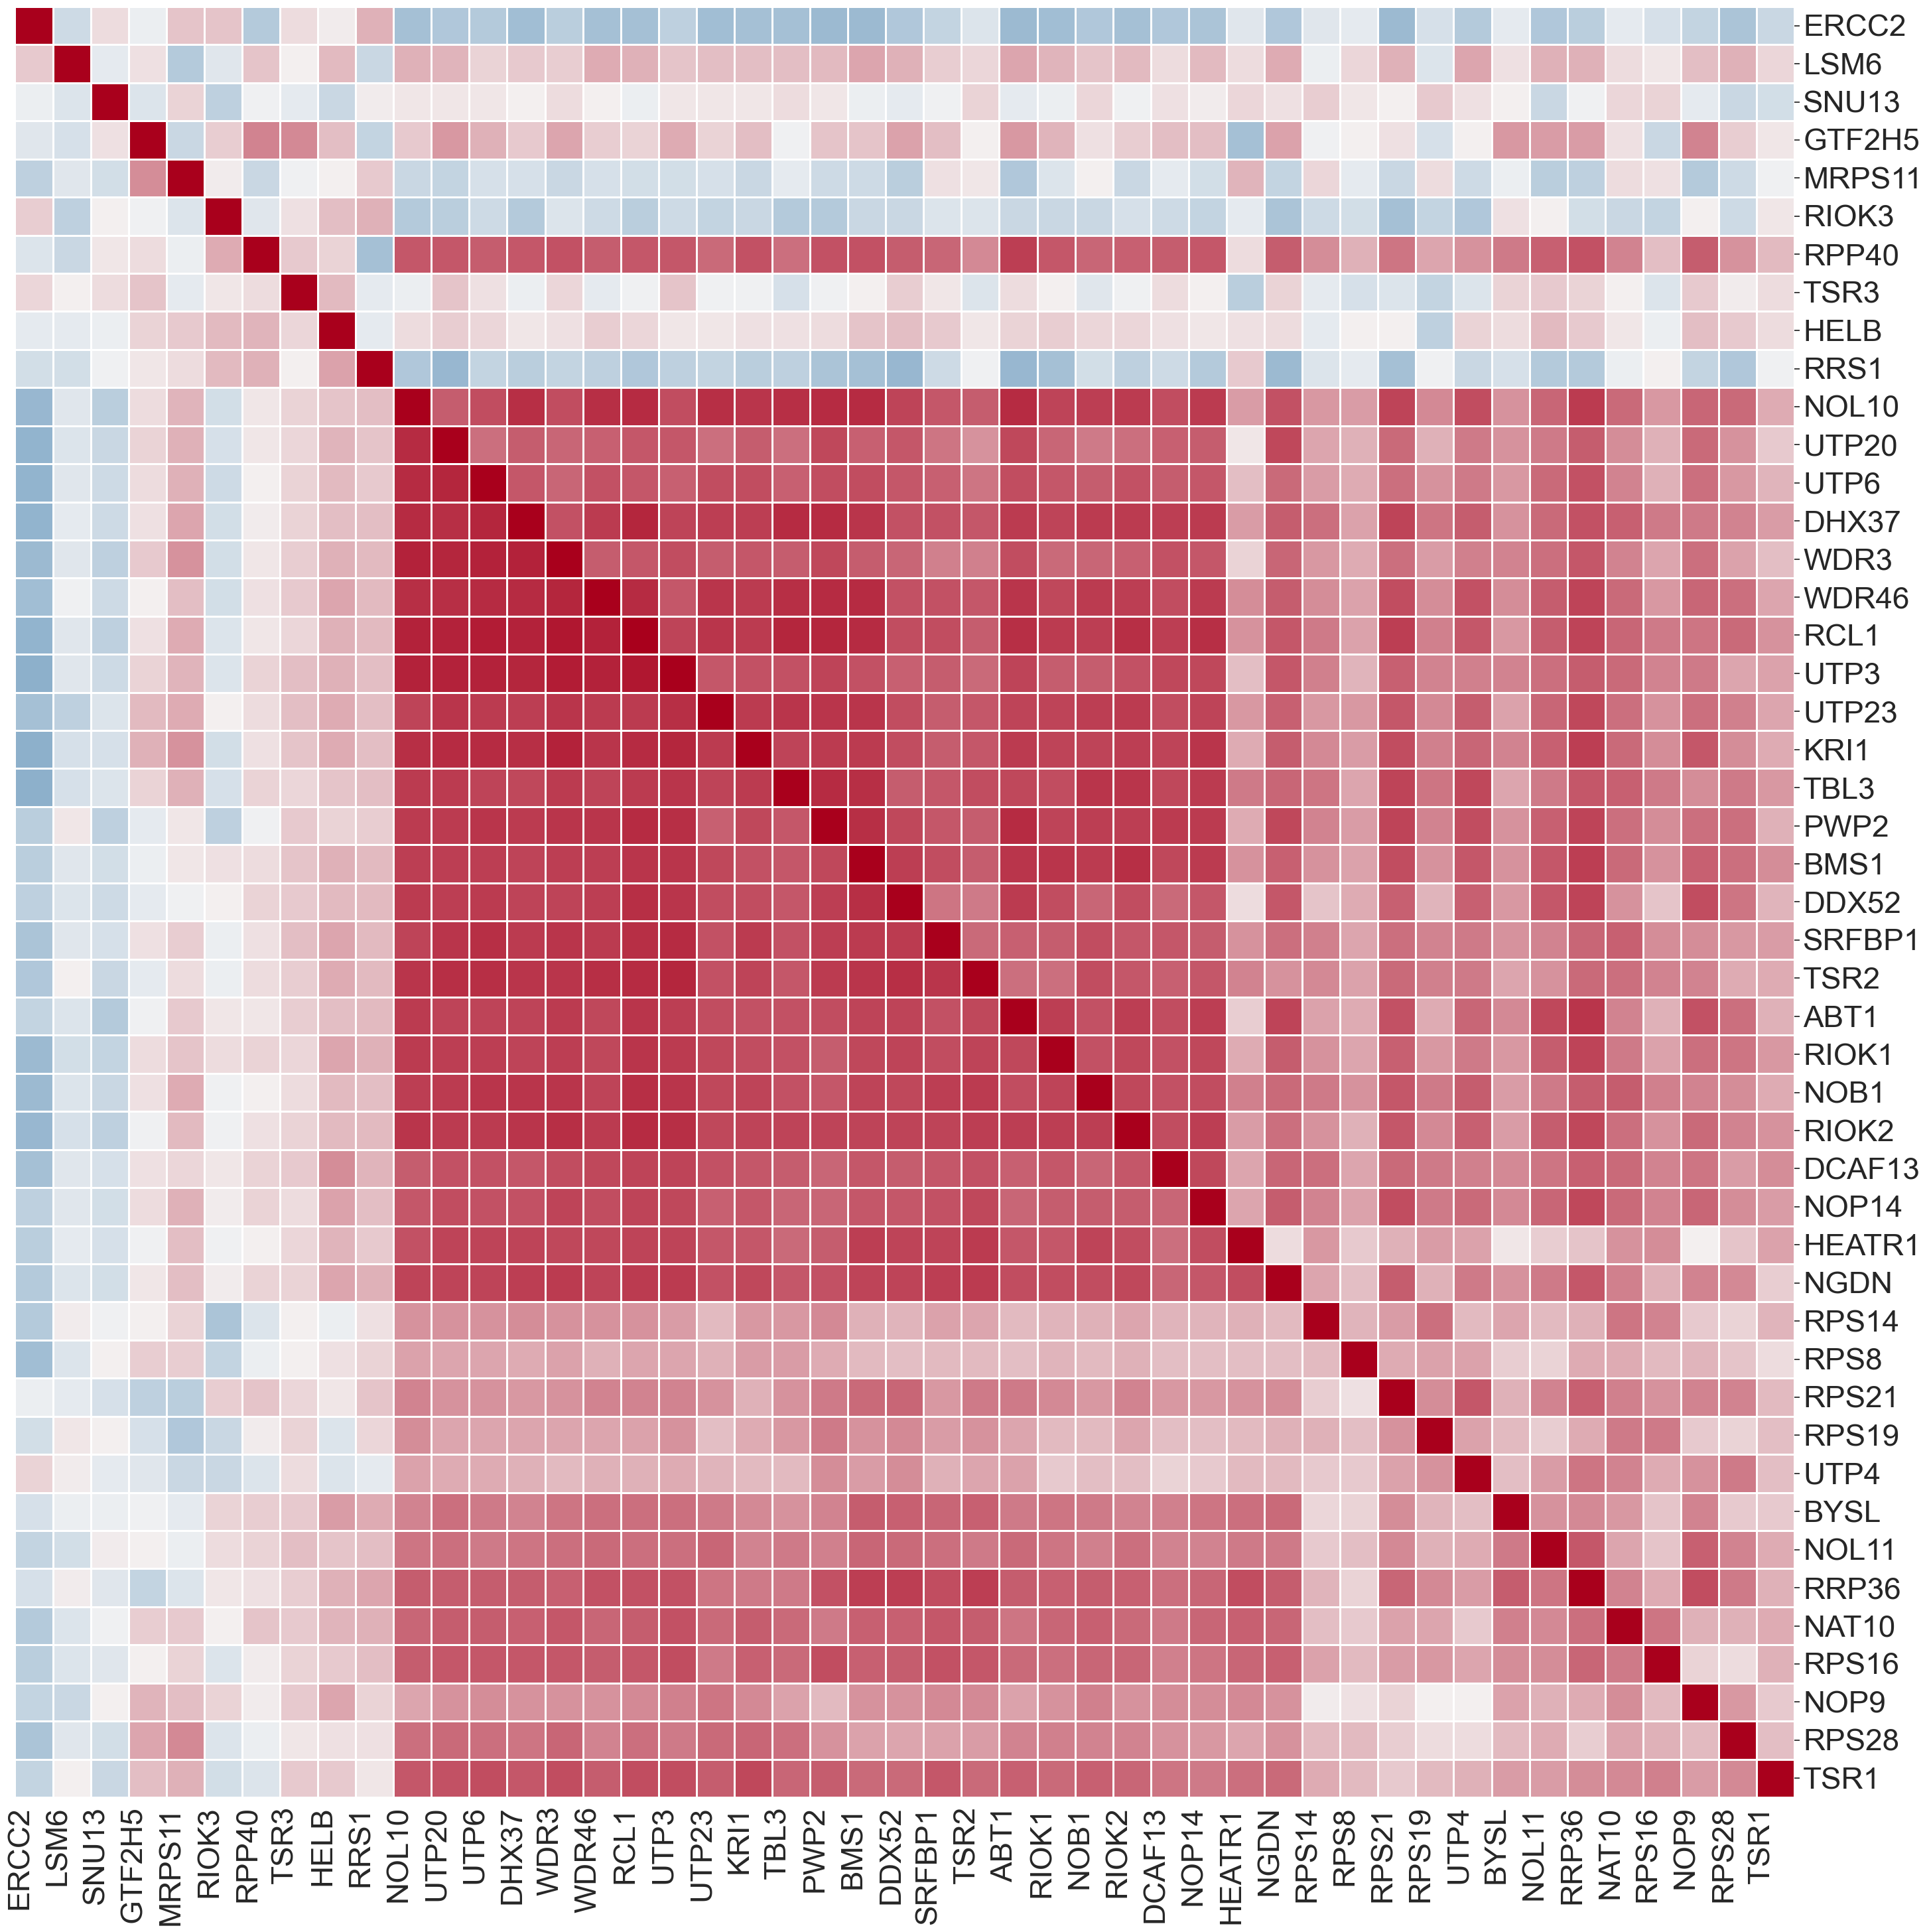

In [17]:
# Clustered based on the HPLM arm first
gene_set = 'MATURATION_OF_SSU_RRNA'
genes = gene_set_dict[gene_set]
coupled_heatmap(df_gene_HPLM,df_gene_DMEM,gene_set,genes,'HPLM_first',3)

<Figure size 1000x1000 with 0 Axes>

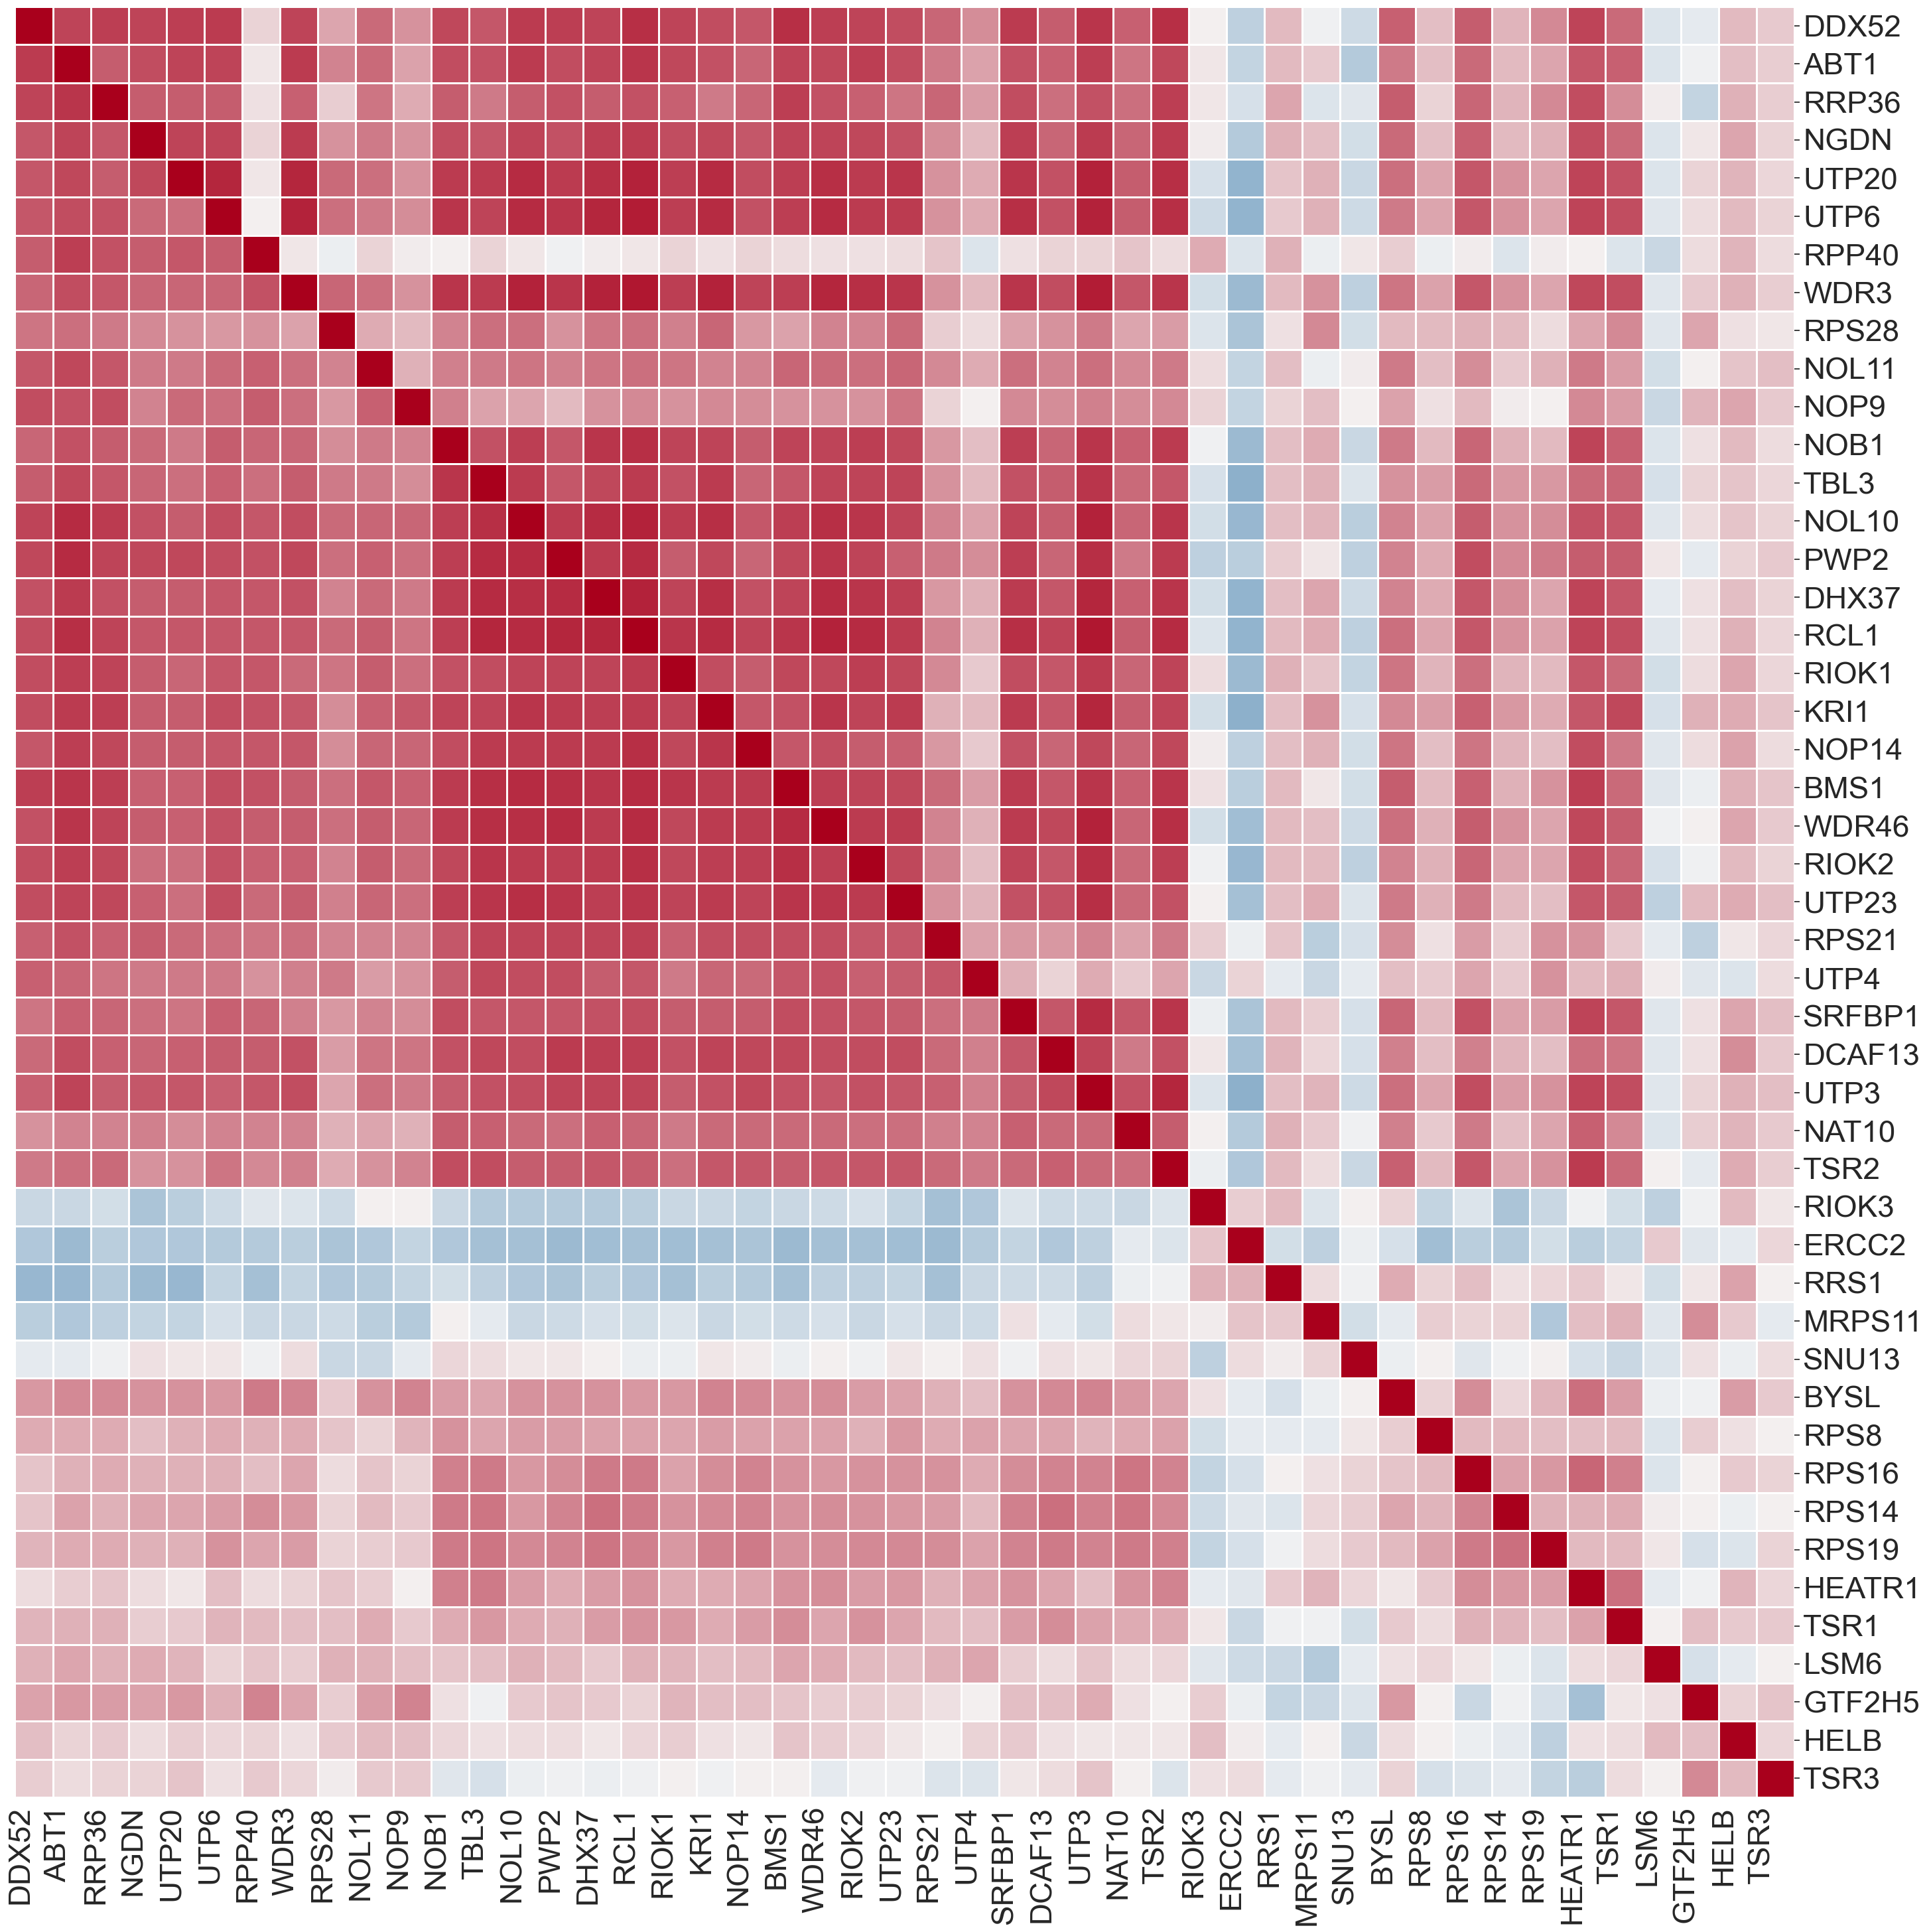

In [18]:
# Clustered based on the DMEM arm first
coupled_heatmap(df_gene_DMEM,df_gene_HPLM,gene_set,genes,'DMEM_first',3)

<Figure size 1000x1000 with 0 Axes>

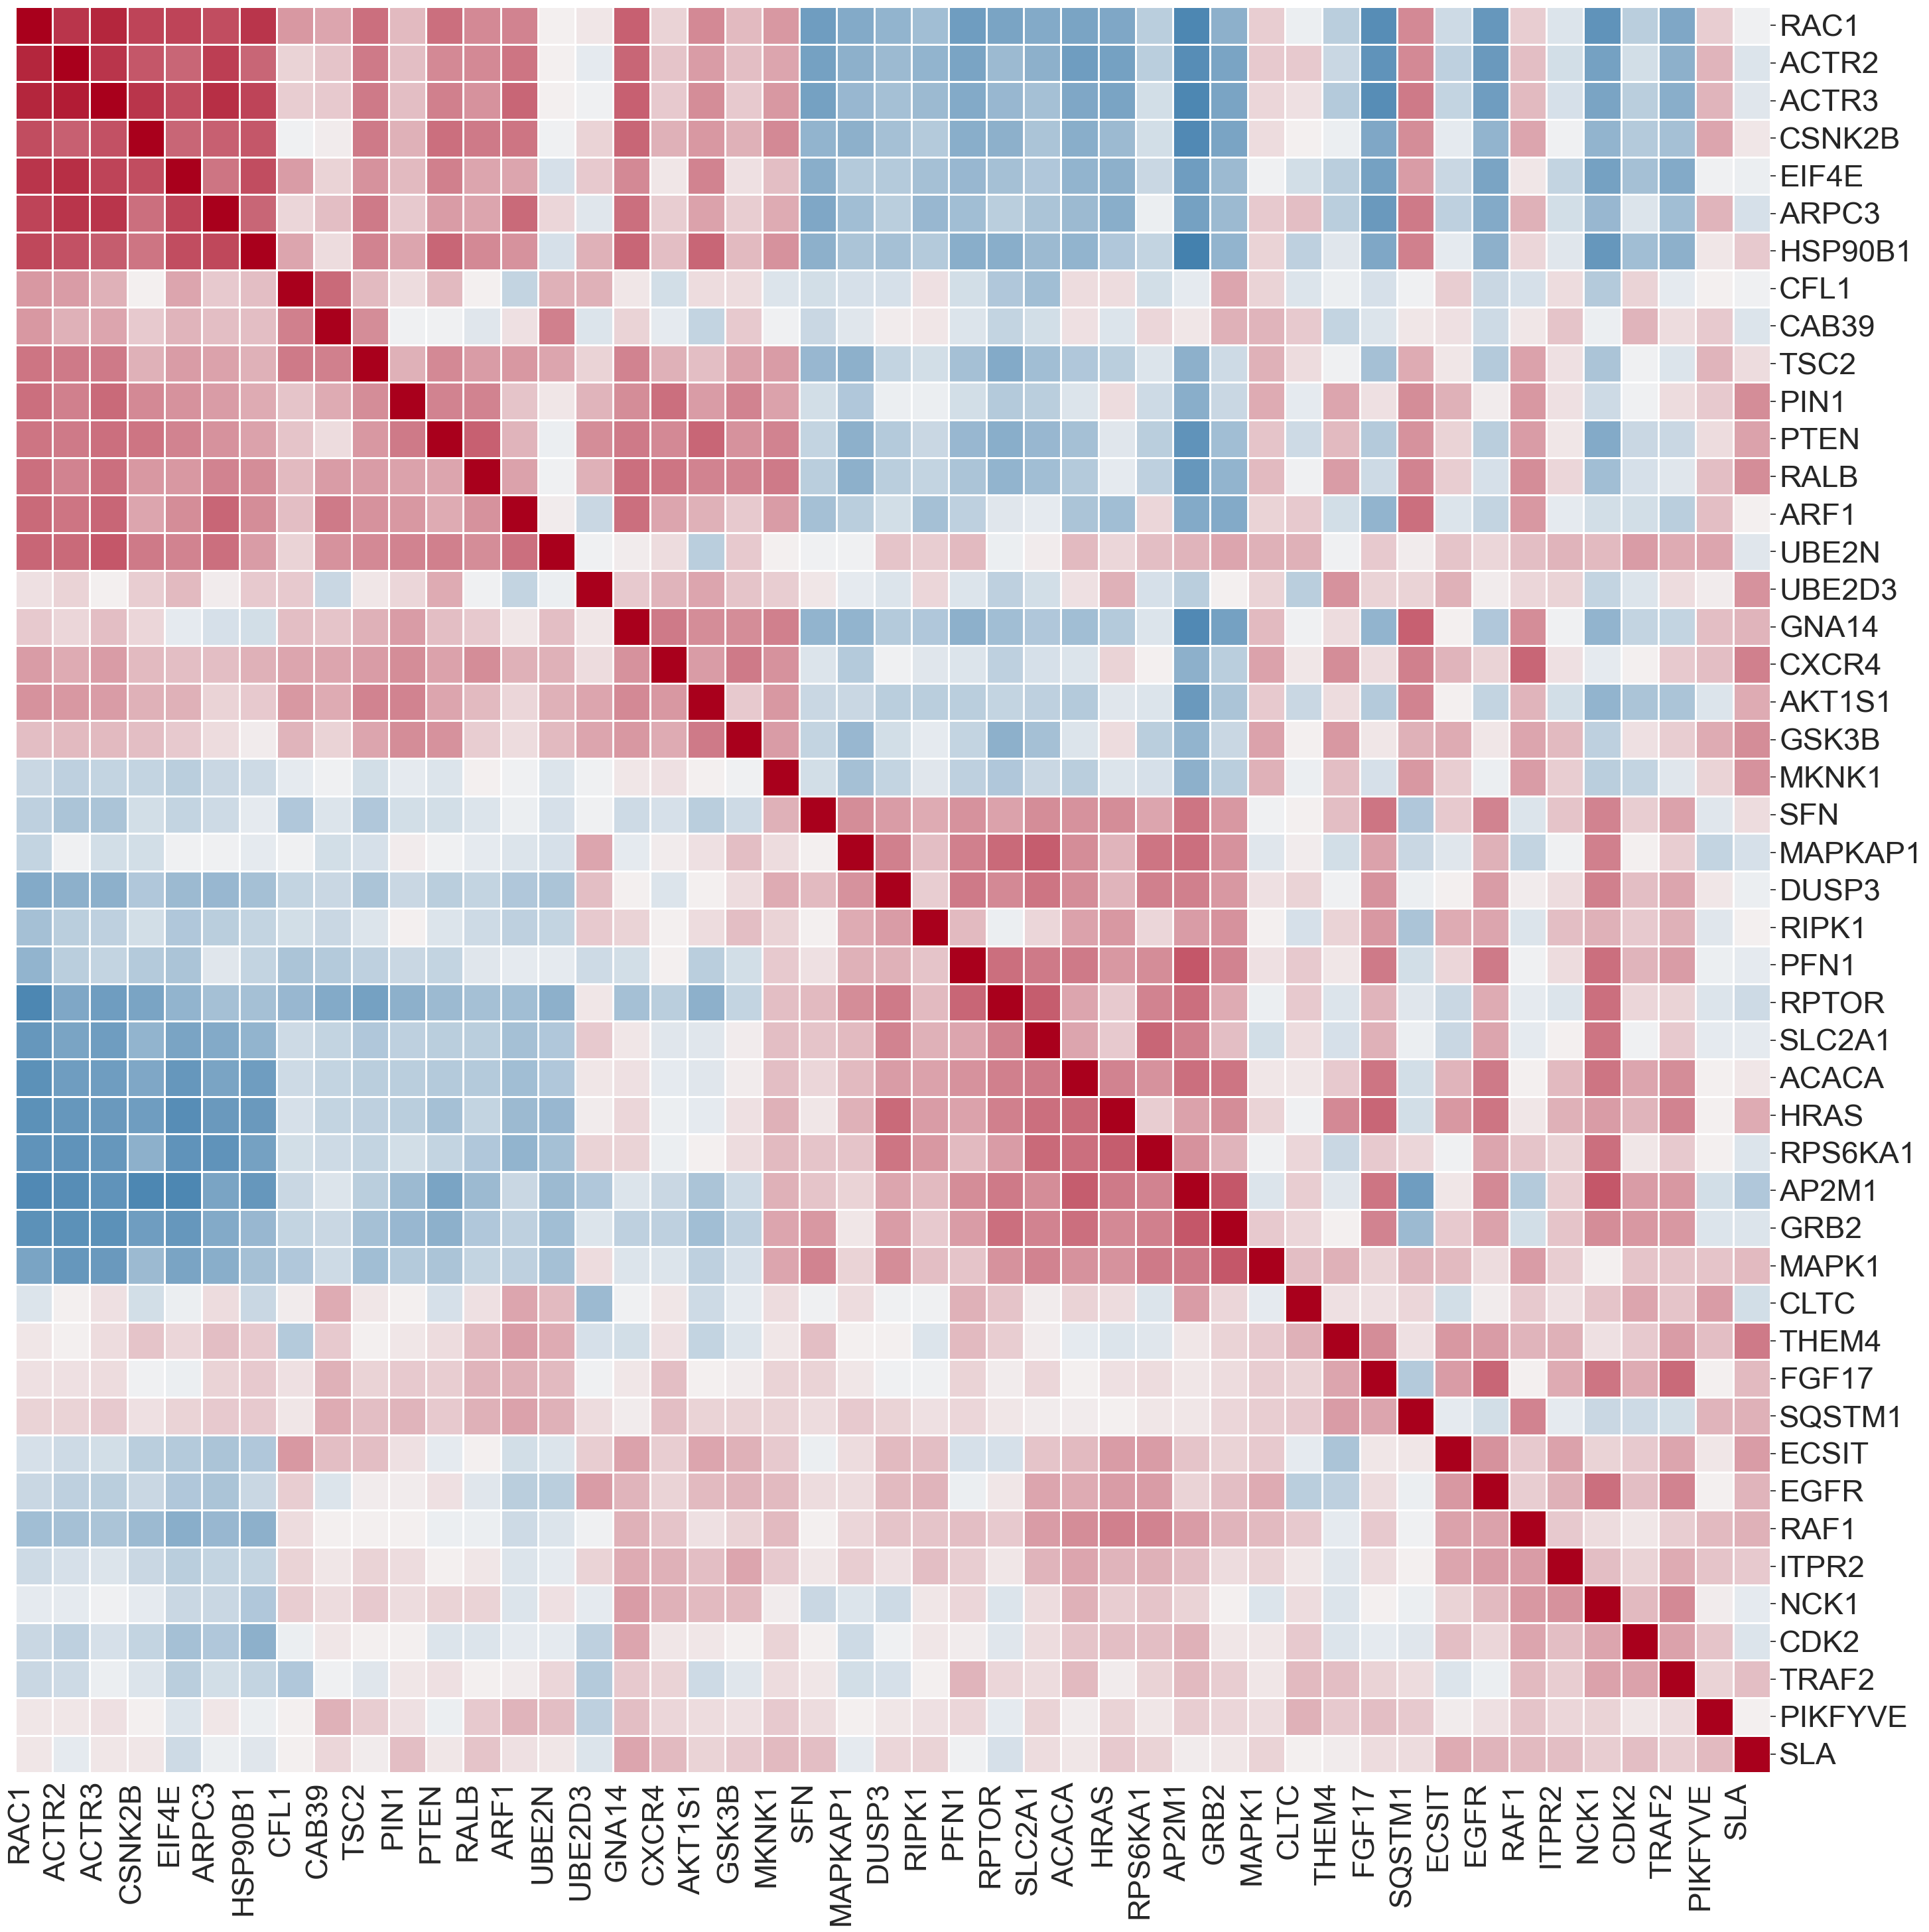

In [19]:
# Clustered based on the HPLM arm first
gene_set = 'PI3KAkt_mTOR_Signaling'
genes = gene_set_dict[gene_set]
coupled_heatmap(df_gene_HPLM,df_gene_DMEM,gene_set,genes,'HPLM_first',3)

<Figure size 1000x1000 with 0 Axes>

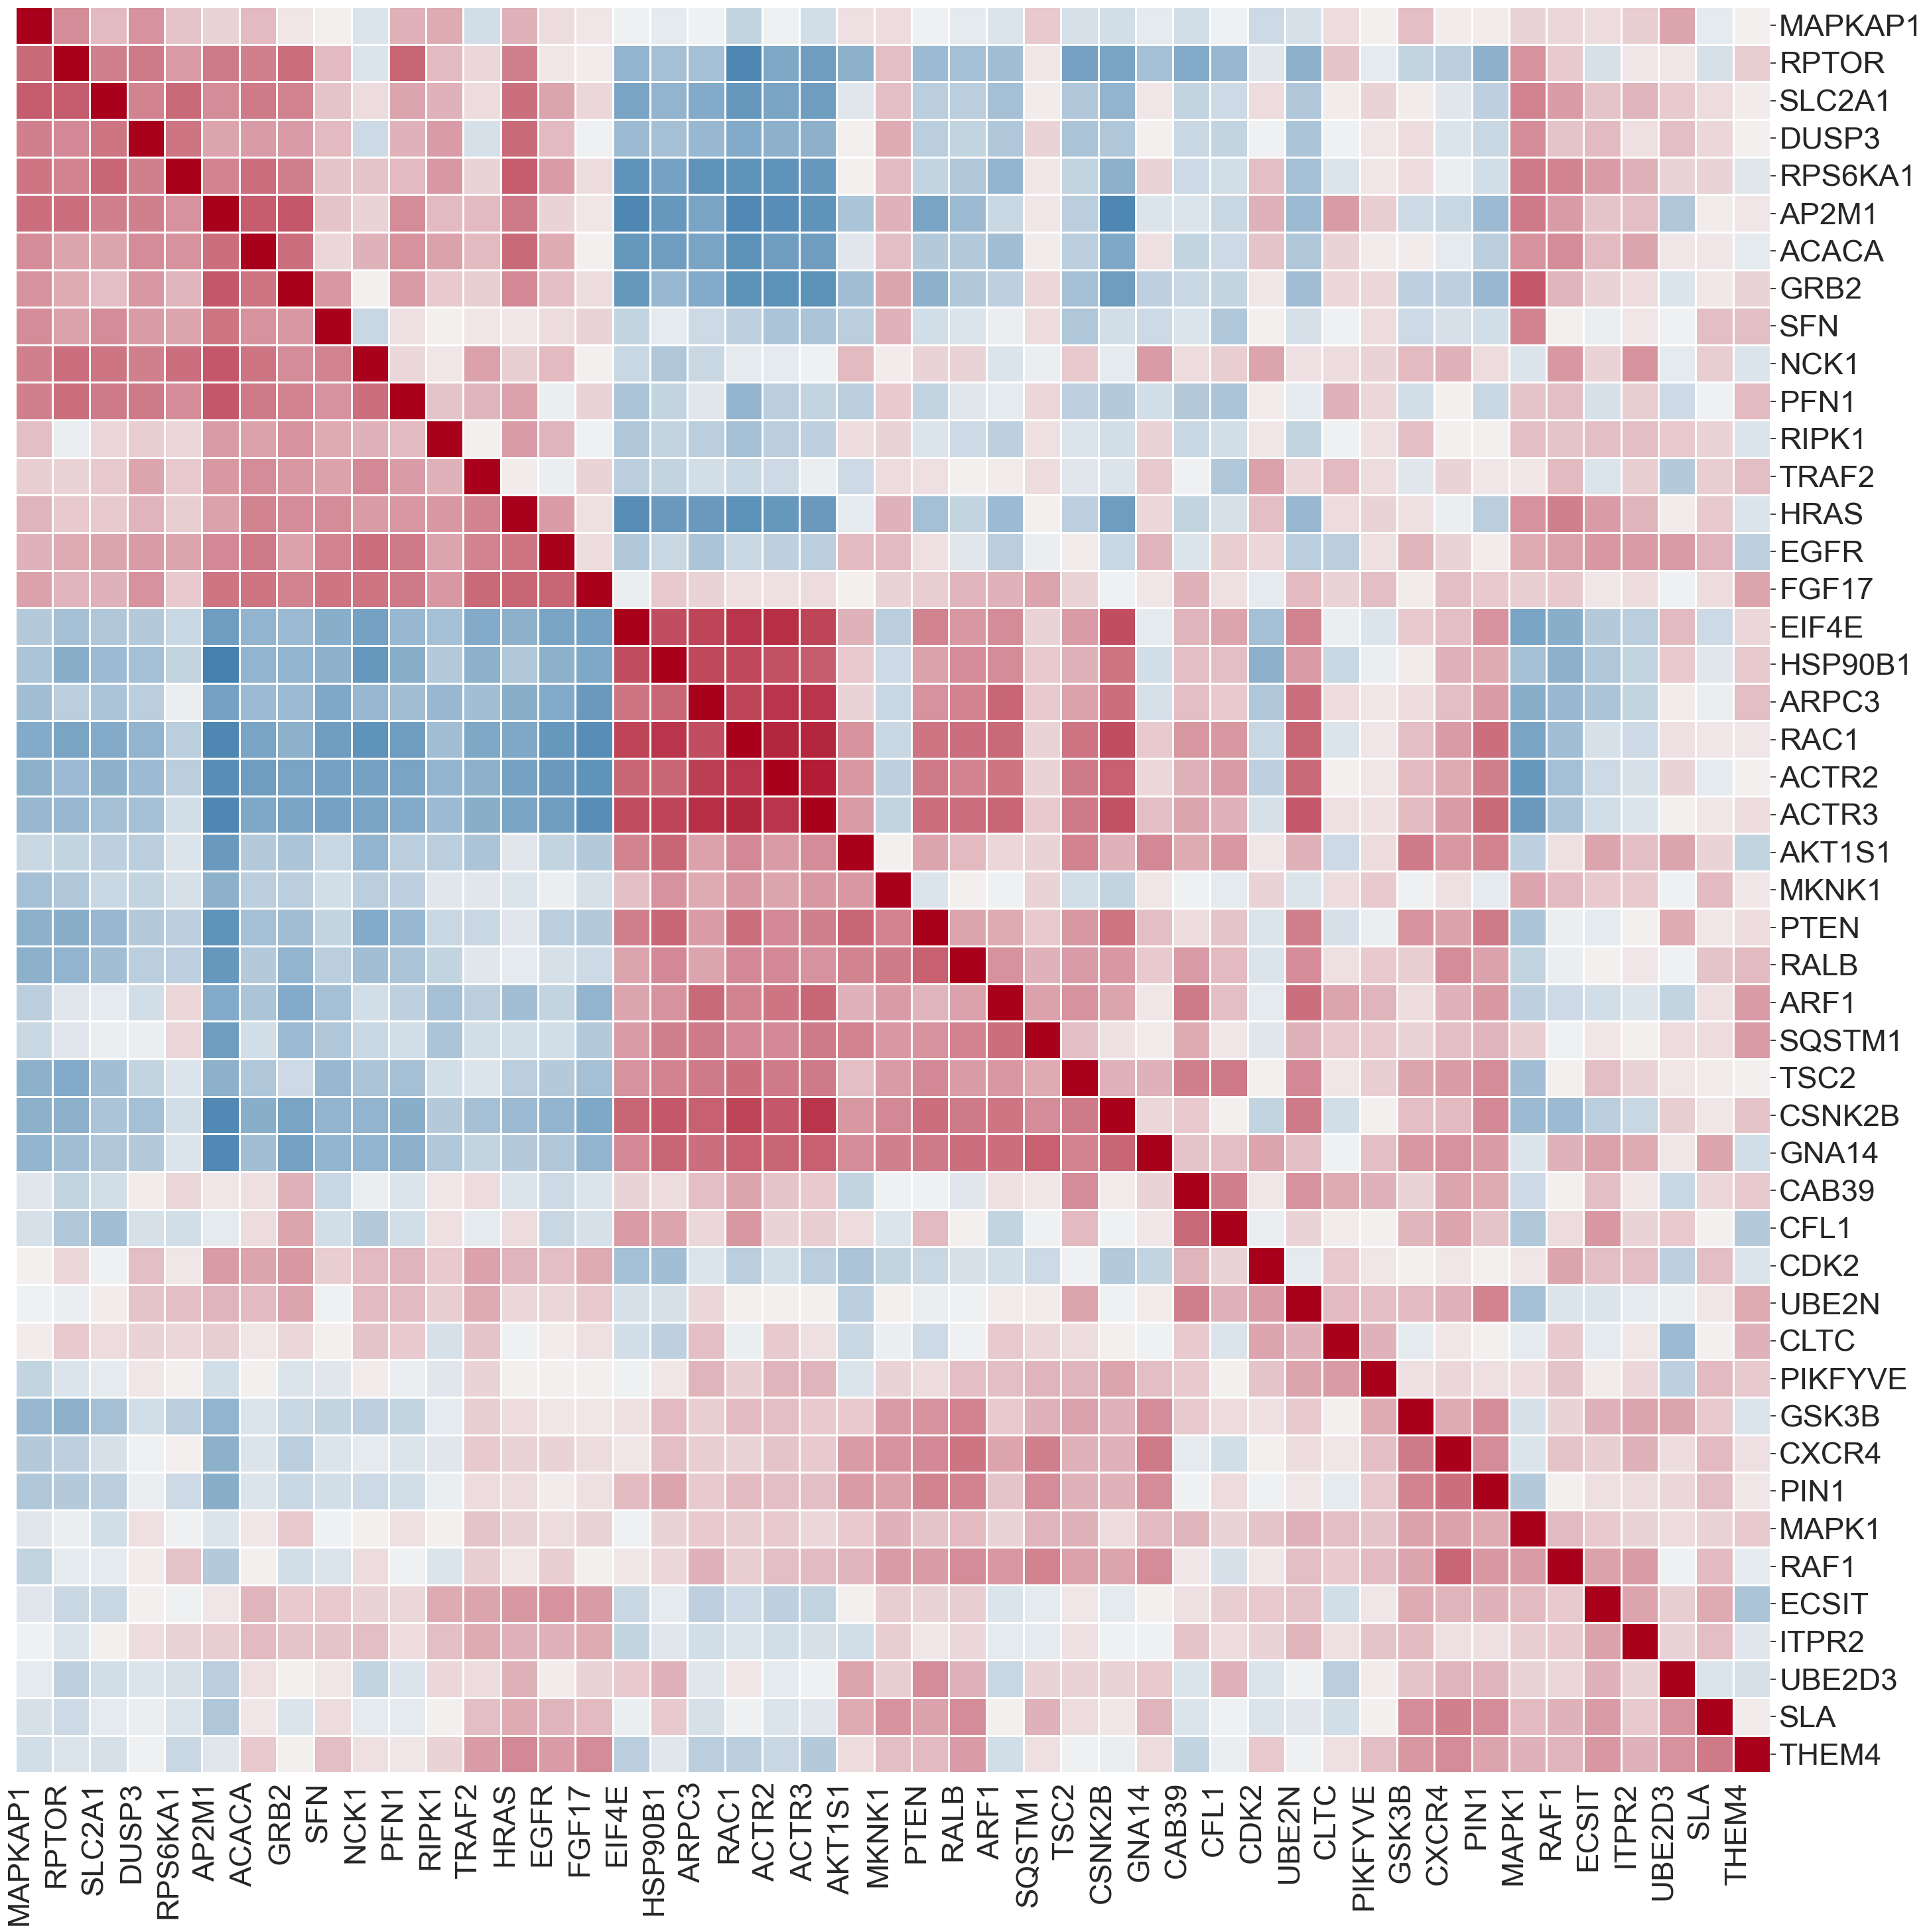

In [20]:
# Clustered based on the DMEM arm first
coupled_heatmap(df_gene_DMEM,df_gene_HPLM,gene_set,genes,'DMEM_first',3)

<Figure size 1000x1000 with 0 Axes>

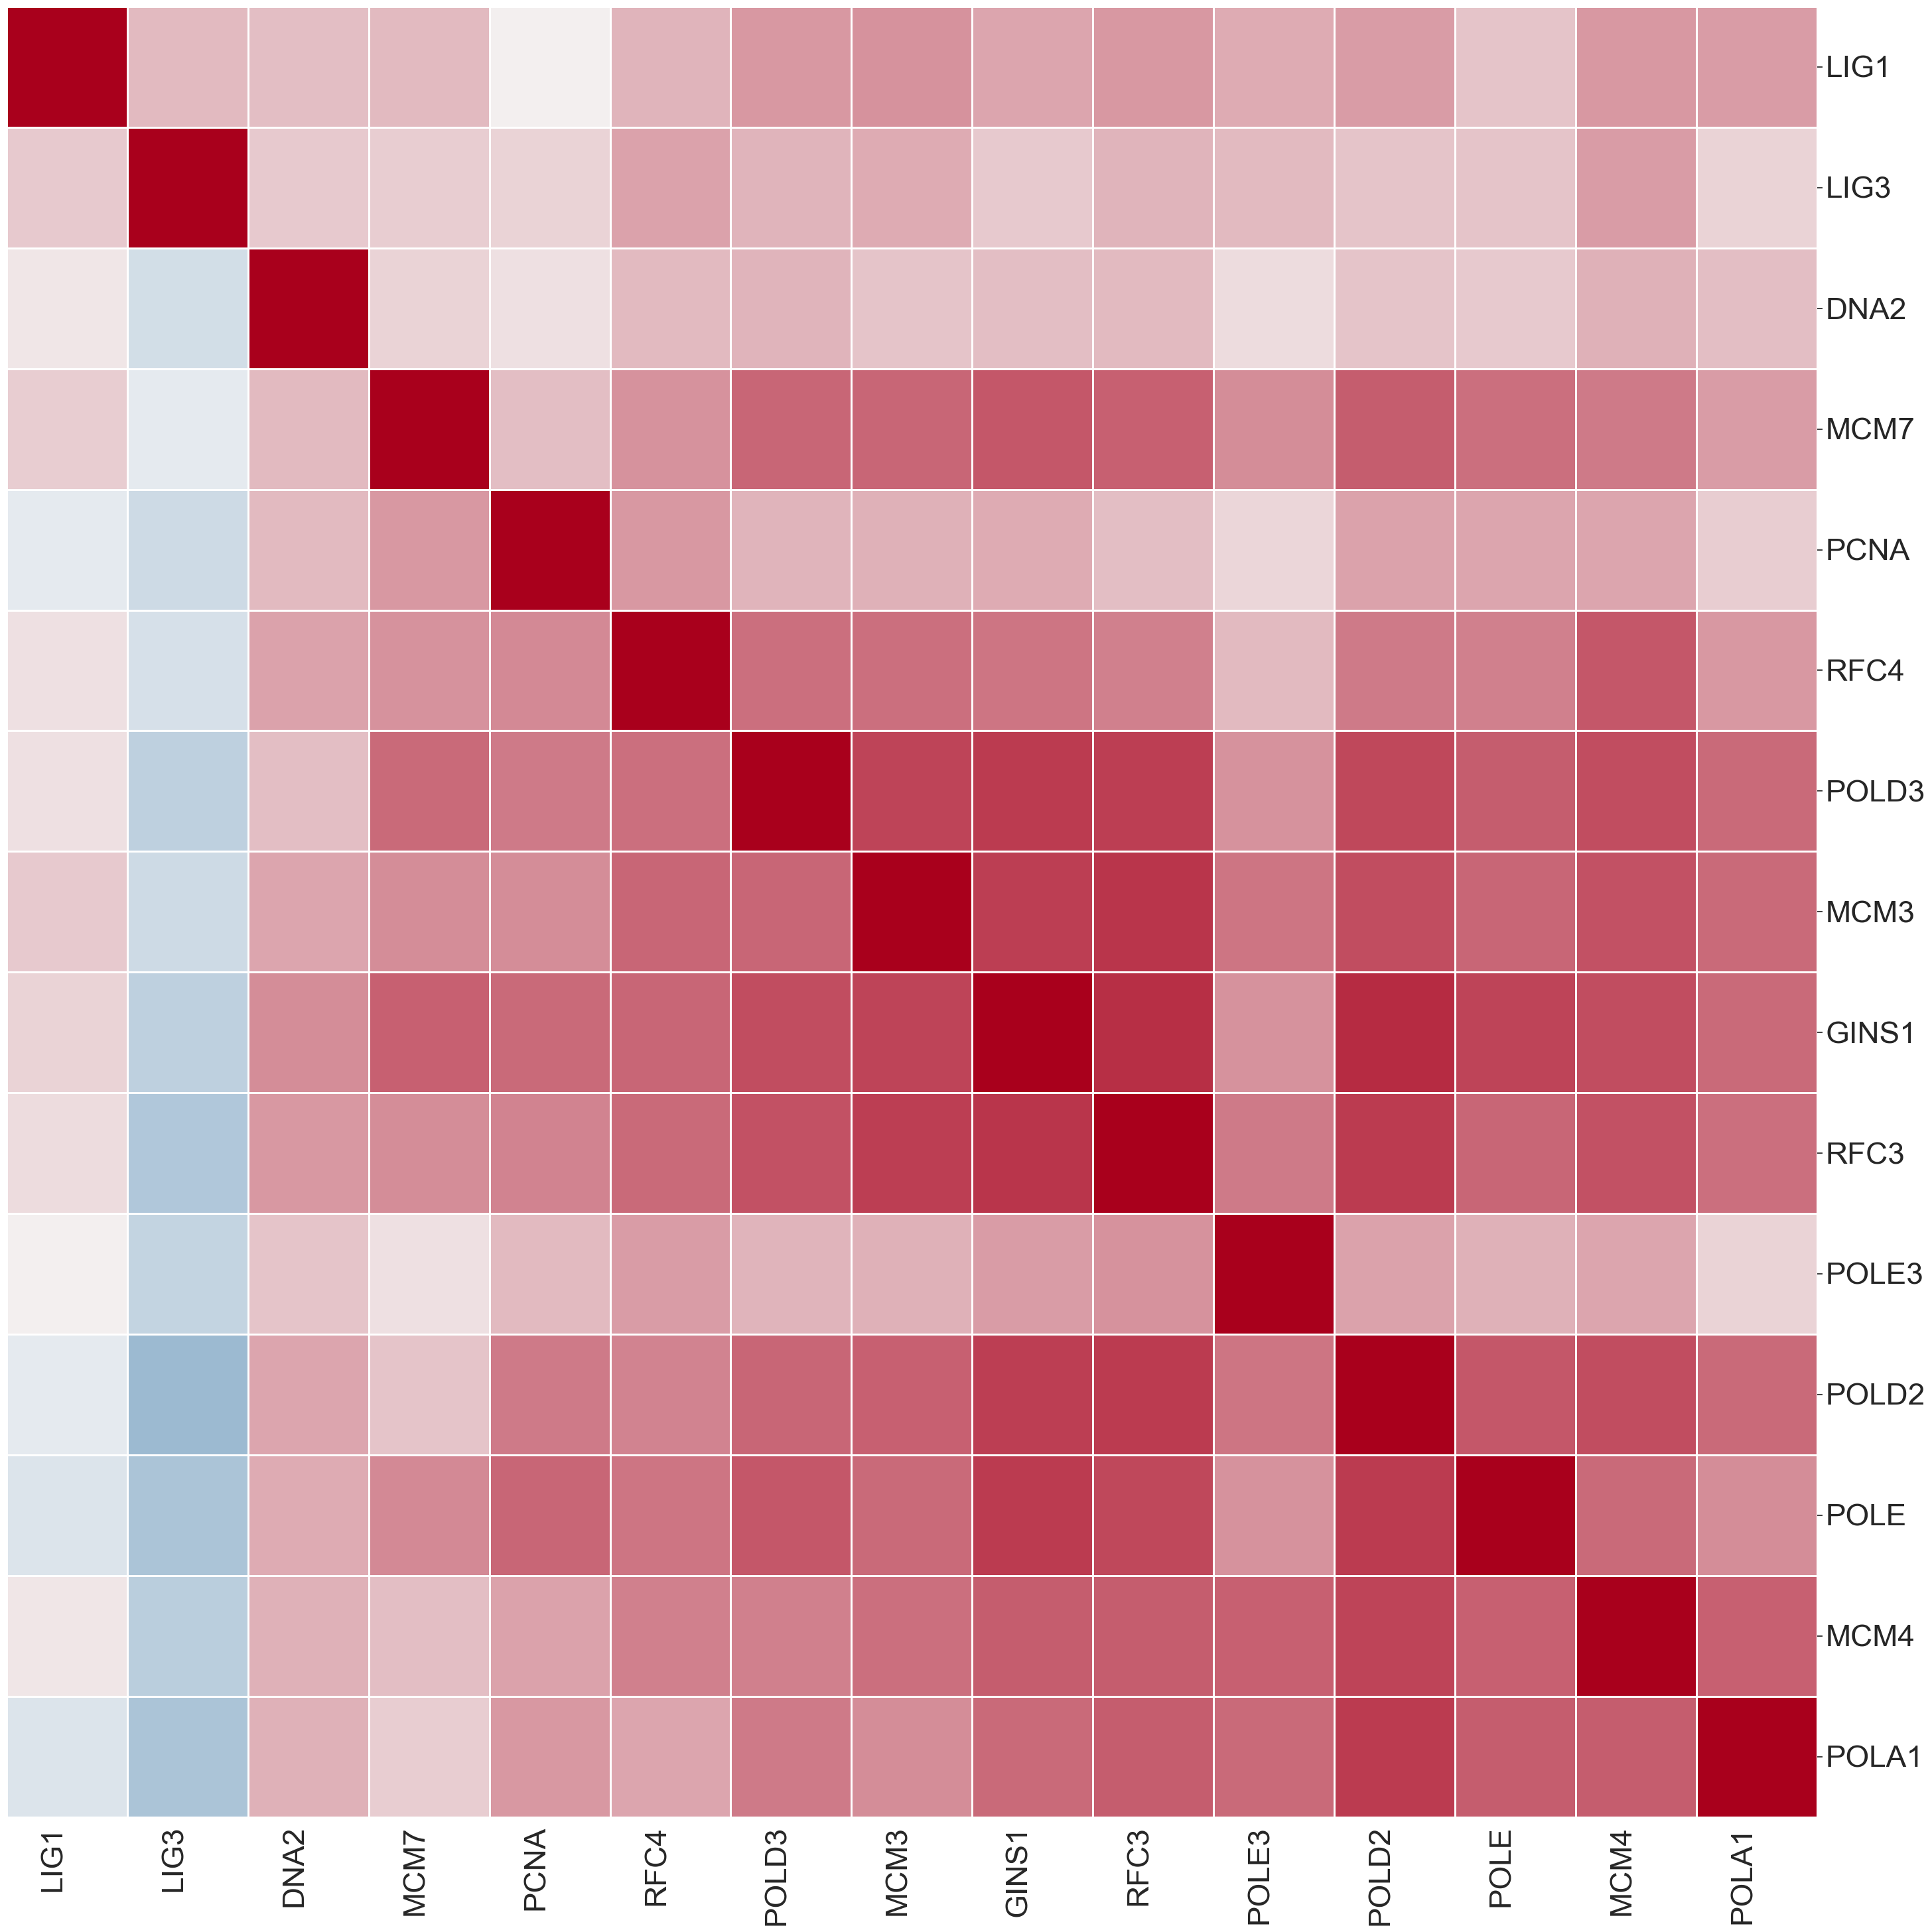

In [21]:
# Clustered based on the HPLM arm first
gene_set = 'DNA_STRAND_ELONGATION_INVOLVED_IN_DNA_REPLICATION'
genes = gene_set_dict[gene_set]
coupled_heatmap(df_gene_HPLM,df_gene_DMEM,gene_set,genes,'HPLM_first',3)

<Figure size 1000x1000 with 0 Axes>

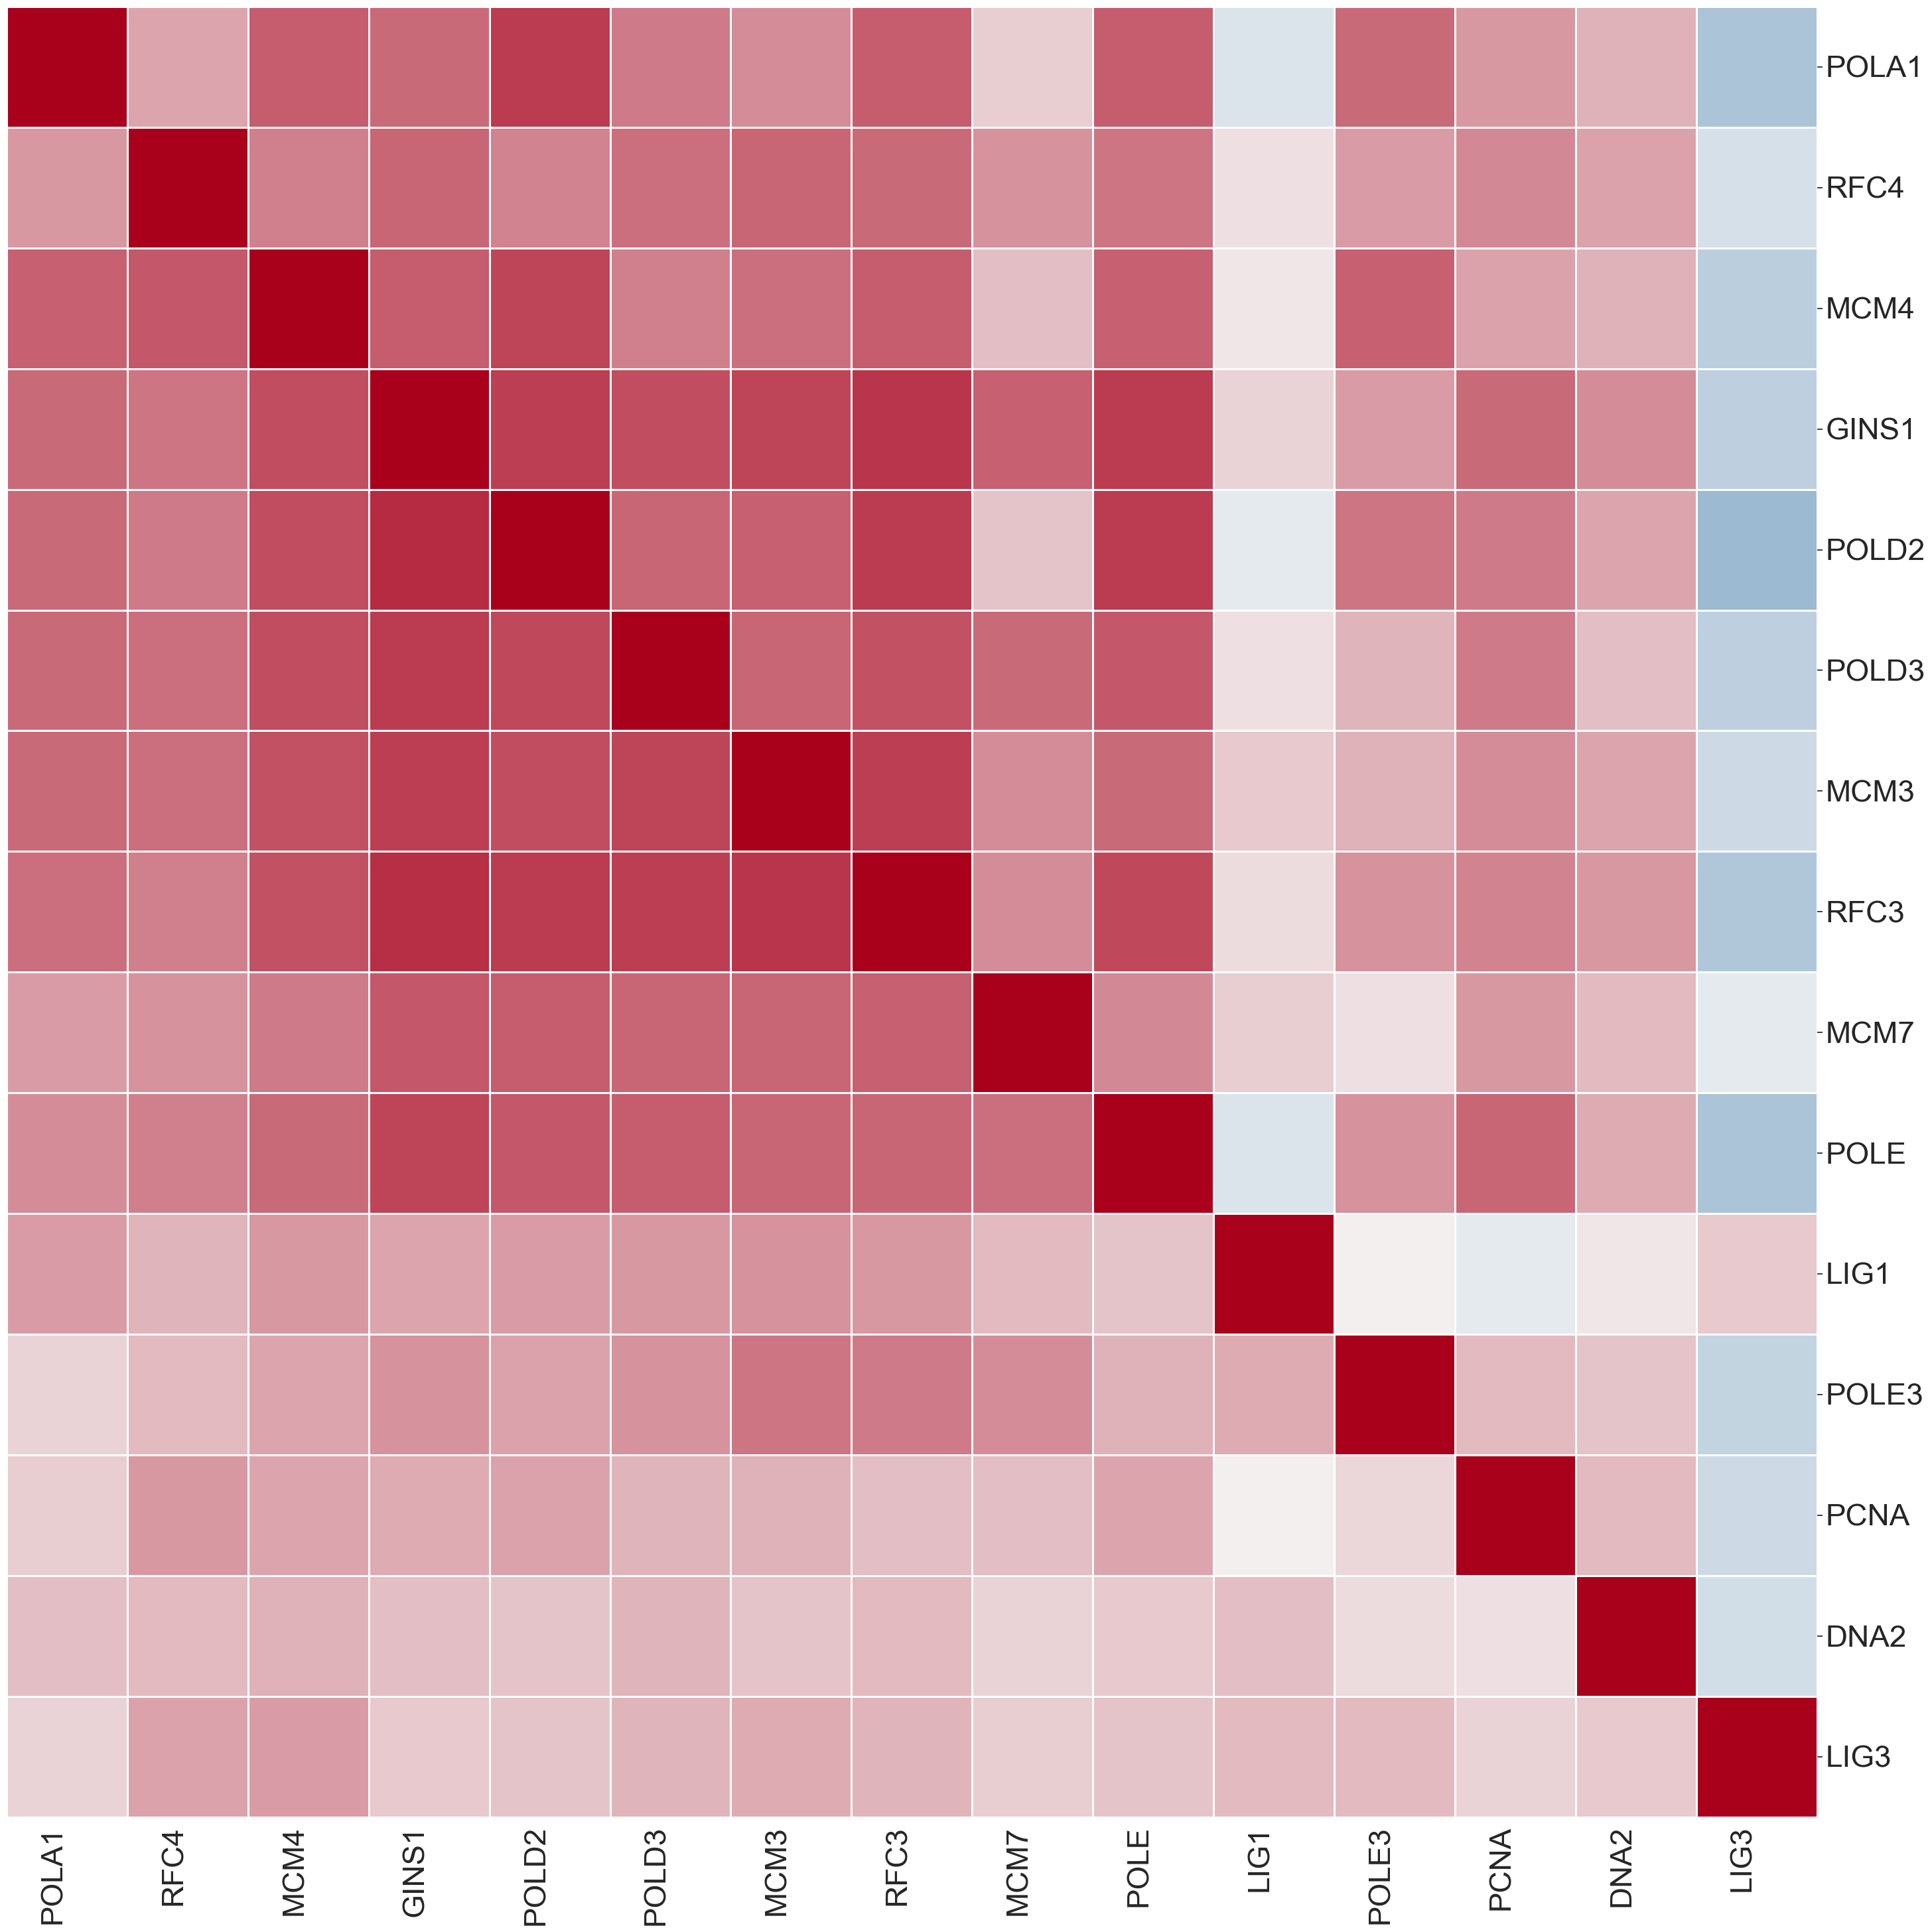

In [22]:
# Clustered based on the DMEM arm first
coupled_heatmap(df_gene_DMEM,df_gene_HPLM,gene_set,genes,'DMEM_first',3)